In [1]:
import astropy as py
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np
from matplotlib import cm
import astropy.units as u
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D 
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import pyspeckit
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'


In [2]:
center_map = SkyCoord("19h37m0.9s","7d34m9.6s")
cutout_size = u.Quantity((50.0, 50.0), u.arcsec)

file_cube_SO_vel = 'Documents/Cube_SO_vel.fits'
file_SO_fit = 'Documents/Spec_SO_vel_fit.fits'
file_cont = 'Downloads/member.uid___A001_X145_X2b3.CB199.cont.pbcor.fits'
file_cont_squeeze = 'Documents/B335_cont.fits'
file_subcube_SO_vel = 'Documents/Sub_Cube_SO.fits'
file_par = 'Documents/Spec_SO_vel_fit.fits'

file_N2Hp = 'Documents/B335/B335_N2Hp_v1_thick_fitted_parameters_snr3.fits'
file_N2Hp_TdV = 'Documents/B335/data/B335_N2H+_10_v1_Tpeak.fits'

# Cutout

In [4]:
def load_cutout(file_in, is_hdu=False) : 
    if is_hdu == False :
        hdu = fits.open(file_in)[0]
    else : 
        hdu = file_in
    cutout = Cutout2D(hdu.data, position=center_map, size=cutout_size, wcs = WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

In [155]:
#frame = 72
#hdu = load_cutout(file_subcube_SO_vel)
#ax = plt.subplot(projection=WCS(hdu.header), slices=('x', 'y', frame))
#ax.coords[2].set_ticklabel(exclude_overlapping=True)
#ax.imshow(hdu.data[frame, :, :].transpose())

In [25]:
Cube_SO = SpectralCube.read(filename="Documents/B335_Combine_SO_rob05_2sigma_automask_clean.fits")
Cube_SO_vel = Cube_SO.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=261.84368400 * u.GHz)
#Cube_SO_vel.write('Documents/Cube_SO_vel.fits', overwrite=True)

In [5]:
Spec_SO = Cube_SO_vel[:, 600,600]
vel_ax = Cube_SO_vel.spectral_axis 

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


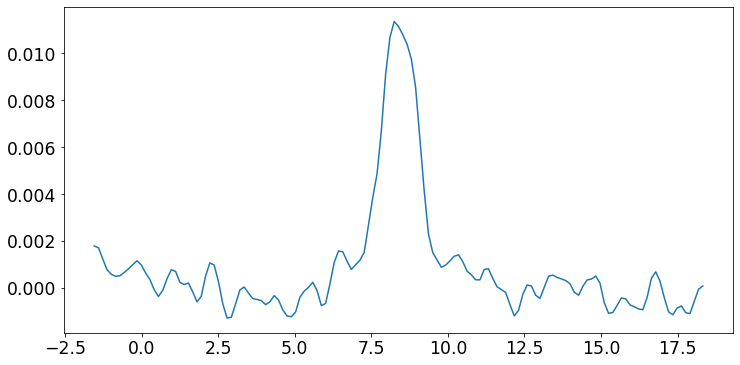

In [6]:
plt.plot(vel_ax, Spec_SO)

# Fit

In [67]:
data_dir = 'data/'
fit_dir = 'fit/'

file_in = 'Documents/Sub_Cube_SO.fits'
#rms_file 
file_par = 'Documents/Spec_SO_vel_fit.fits'

freq_line = 261.84368400 * u.GHz
snr_min = 5.0
xmax = 125; ymax = 125
# range of parameters
vmin = 2.5; vmax = 12.5
tpeak_min = 0.0; tpeak_max = 500e-3
dv_min = 0.02; dv_max = 4.0

# Load cube and setup the spectral axis
cube = pyspeckit.Cube(file_in)
cube.xarr.refX = freq_line
cube.xarr.velocity_convention = 'radio'
cube.xarr.convert_to_unit('km/s')

err_map = np.ones((250, 250))*0.0015
# Initial guess value
guesses = np.array([80e-3, 8.34, 0.5])

cube.fiteach(guesses=guesses,
    start_from_point=(xmax, ymax),
    fittype='gaussian', blank_value=np.nan,verbose_level=3,
    use_neighbor_as_guess=True,
    limitedmax=[True, True, True],
    limitedmin=[True, True, False],
    maxpars=[tpeak_max, vmax, dv_max],
    minpars=[tpeak_min, vmin, dv_min],
    multicore=1, errmap=err_map, signal_cut=snr_min)

cube.write_fit(file_par, overwrite=True)

INFO: Fitting up to 62500 spectra [pyspeckit.cubes.SpectralCube]
INFO: Fitting  125, 125 (s/n=7.6) [pyspeckit.cubes.SpectralCube]
INFO: Using input guess [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      1 of  62500 at ( 125, 125) s/n=  7.6. Elapsed time is 0.1 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,144 [pyspeckit.spectrum.interactive]
INFO: Fitting  125, 125 (s/n=7.6) [pyspeckit.cubes.SpectralCube]
INFO: Using input guess [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      1 of  62500 at ( 125, 125) s/n=  7.6. Elapsed time is 0.3 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  126, 125 (s/n=9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      2 of  62500 at ( 126, 125) s/n=  9.0. Elapsed time is 0.4 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  125, 126 (s/n=7.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit      3 of  62500 at ( 125, 126) s/n=  7.5. Elapsed time is 0.5 seconds.  

INFO: Finished fit     42 of  62500 at ( 122, 123) s/n=  7.4. Elapsed time is 5.1 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  128, 127 (s/n=12) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     43 of  62500 at ( 128, 127) s/n= 11.6. Elapsed time is 5.3 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  123, 122 (s/n=8.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     44 of  62500 at ( 123, 122) s/n=  8.5. Elapsed time is 5.4 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  128, 123 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     45 of  62500 at ( 128, 123) s/n= 10.6. Elapsed time is 5.5 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  125, 129 (s/n=7.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     46 of  62500 at ( 125, 129) s/n=  7.3. Elapsed time is 5.7 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  125, 121 (s/n=8.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     47 of  62500 at ( 125, 1

INFO: Finished fit     91 of  62500 at ( 120, 123) s/n=  7.4. Elapsed time is 11.4 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  130, 123 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     92 of  62500 at ( 130, 123) s/n= 14.2. Elapsed time is 11.5 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  127, 130 (s/n=8.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     93 of  62500 at ( 127, 130) s/n=  8.2. Elapsed time is 11.6 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  123, 130 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     94 of  62500 at ( 123, 130) s/n=  5.0. Elapsed time is 11.8 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  123, 120 (s/n=8.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     95 of  62500 at ( 123, 120) s/n=  8.9. Elapsed time is 11.9 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  127, 120 (s/n=8.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit     96 of  62500 at ( 12

INFO: Finished fit    142 of  62500 at ( 131, 128) s/n= 13.2. Elapsed time is 17.1 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 128 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  128, 119 (s/n=9.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    144 of  62500 at ( 128, 119) s/n=  9.7. Elapsed time is 17.2 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  122, 119 (s/n=7.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    145 of  62500 at ( 122, 119) s/n=  7.9. Elapsed time is 17.4 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  132, 125 (s/n=15) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    146 of  62500 at ( 132, 125) s/n= 15.5. Elapsed time is 17.5 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  125, 132 (s/n=5.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    147 of  62500 at ( 125, 132) s/n=  5.6. Elapsed time is 17.6 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 125 (s/n=4.8) [pyspecki

INFO: Finished fit    194 of  62500 at ( 125, 117) s/n=  5.9. Elapsed time is 23.1 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 133 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  133, 125 (s/n=15) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    196 of  62500 at ( 133, 125) s/n= 14.8. Elapsed time is 23.2 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 125 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  129, 132 (s/n=8.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    198 of  62500 at ( 129, 132) s/n=  8.7. Elapsed time is 23.4 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  132, 129 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    199 of  62500 at ( 132, 129) s/n= 11.4. Elapsed time is 23.5 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 129 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  133, 126 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    201 of  62500 at (

INFO: Finished fit    248 of  62500 at ( 133, 129) s/n= 10.7. Elapsed time is 29.5 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 129 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 134 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 125 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    251 of  62500 at ( 134, 125) s/n= 13.6. Elapsed time is 29.6 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 116 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 125 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 116 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 124 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    255 of  62500 at ( 134, 124) s/n= 13.9. Elapsed time is 29.8 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 124 (s/n=4.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 126 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 126 (s/n=13) [pysp

INFO: Finished fit    310 of  62500 at ( 133, 119) s/n= 15.3. Elapsed time is 34.9 seconds.  %0 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 117 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 115 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  131, 117 (s/n=12) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    313 of  62500 at ( 131, 117) s/n= 12.4. Elapsed time is 35.4 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 133 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  131, 133 (s/n=8.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    315 of  62500 at ( 131, 133) s/n=  8.2. Elapsed time is 35.5 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 135 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 125 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 126 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  135, 124 (s/n=12) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    319 of  62500 

INFO: Fitting  136, 124 (s/n=10) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    382 of  62500 at ( 136, 124) s/n= 10.5. Elapsed time is 40.5 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 136 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 114 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 114 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 123 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  136, 123 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    387 of  62500 at ( 136, 123) s/n= 10.8. Elapsed time is 40.7 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 115 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 136 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 114 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 135 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  130, 135 (s/n=5.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    392 of  62500

INFO: Finished fit    454 of  62500 at ( 133, 134) s/n=  6.6. Elapsed time is 45.9 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 117 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    455 of  62500 at ( 134, 117) s/n= 14.2. Elapsed time is 46.1 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 137 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 113 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 130 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  130, 114 (s/n=7.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    459 of  62500 at ( 130, 114) s/n=  7.2. Elapsed time is 46.4 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  136, 120 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    460 of  62500 at ( 136, 120) s/n= 11.4. Elapsed time is 46.6 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 114 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 136 (s/n=3) [pyspec

INFO: Fitting  137, 130 (s/n=5.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    528 of  62500 at ( 137, 130) s/n=  5.4. Elapsed time is 52.3 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 112 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  138, 124 (s/n=7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    531 of  62500 at ( 138, 124) s/n=  7.0. Elapsed time is 52.5 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  136, 118 (s/n=12) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    532 of  62500 at ( 136, 118) s/n= 11.7. Elapsed time is 52.6 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 112 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 124 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 136 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 114 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 136 (s/n=2.6) [py

INFO: Skipped  125, 111 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 139 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 125 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  139, 125 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    613 of  62500 at ( 139, 125) s/n=  5.0. Elapsed time is 58.2 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 139 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  139, 124 (s/n=5.8) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    615 of  62500 at ( 139, 124) s/n=  5.8. Elapsed time is 58.3 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 126 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 139 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 126 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 111 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 124 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 111 (s/n=3.3) [py

INFO: Finished fit    705 of  62500 at ( 137, 116) s/n= 10.9. Elapsed time is 63.8 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 134 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 140 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 113 (s/n=10) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    708 of  62500 at ( 134, 113) s/n= 10.3. Elapsed time is 64.0 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 134 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 124 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 110 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 126 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 126 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 110 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 124 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 140 (s/n=1) 

INFO: Skipped  141, 123 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 117 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 139 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 133 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 133 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 111 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 109 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 127 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 141 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 127 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  133, 111 (s/n=7.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    817 of  62500 at ( 133, 111) s/n=  7.3. Elapsed time is 70.0 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 141 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  139, 117 (s/n=7.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    819 of  62

INFO: Skipped  114, 138 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 114 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 138 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 124 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 136 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  136, 112 (s/n=7.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit    915 of  62500 at ( 136, 112) s/n=  7.7. Elapsed time is 74.9 seconds.  %1 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 136 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 131 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 119 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 109 (s/n=4.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 119 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 131 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 141 (s/n

INFO: Finished fit   1016 of  62500 at ( 140, 115) s/n=  5.8. Elapsed time is 79.5 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 143 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 143 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 108 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 124 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 131 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 107 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 126 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 108 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 126 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 119 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 131 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 142 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 140 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 107 (s/n=2.5) [

INFO: Skipped  106, 124 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 106 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 106 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 124 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 126 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 144 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 126 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  138, 111 (s/n=6.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1138 of  62500 at ( 138, 111) s/n=  6.6. Elapsed time is 84.6 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 127 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 144 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 139 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 127 (s/n=2

INFO: Skipped  144, 131 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 144 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 119 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 131 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 119 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 105 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 137 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 137 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  141, 113 (s/n=5.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1249 of  62500 at ( 141, 113) s/n=  5.2. Elapsed time is 90.8 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 113 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 109 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 141 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137, 109 (s/n

INFO: Finished fit   1357 of  62500 at ( 137, 108) s/n=  6.6. Elapsed time is 95.0 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 142 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  142, 113 (s/n=5.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1359 of  62500 at ( 142, 113) s/n=  5.1. Elapsed time is 95.2 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 137 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 119 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 131 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 131 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 105 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 105 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 119 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 145 (s/n=1.

INFO: Skipped  146, 130 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 146 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 120 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 146 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 137 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 107 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  143, 113 (s/n=5.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1477 of  62500 at ( 143, 113) s/n=  5.3. Elapsed time is 99.4 seconds.  %2 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 143 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 137 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137, 107 (s/n=6.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1481 of  62500 at ( 137, 107) s/n=  6.6. Elapsed time is 99.6 seconds.  

INFO: Skipped  121, 147 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 129 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 106 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 144 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137, 106 (s/n=6.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1584 of  62500 at ( 137, 106) s/n=  6.4. Elapsed time is 103.4 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 117 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 144 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 117 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 104 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 133 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 146 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 104 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 137 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  144, 113 (s/

INFO: Skipped  128, 102 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 128 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 104 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 104 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 146 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 135 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 115 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 146 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 115 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137, 105 (s/n=6.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1702 of  62500 at ( 137, 105) s/n=  6.4. Elapsed time is 107.6 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 105 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 137 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 145 (s/

INFO: Skipped  126, 149 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 124 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 126 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 126 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 149 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 132 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 108 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 102 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 102 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 142 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 132 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 142 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 148 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 118 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 118 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 148 (s/

INFO: Skipped  134, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 146 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  146, 112 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1910 of  62500 at ( 146, 112) s/n= 13.6. Elapsed time is 115.6 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  138, 104 (s/n=8.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   1911 of  62500 at ( 138, 104) s/n=  8.9. Elapsed time is 115.7 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 138 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 102 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 138 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 134 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 134 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 131 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 119 (s/n=3

INFO: Skipped  133, 149 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 133 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 121 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 150 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 129 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 129 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 100 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 100 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 121 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 143 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  143, 107 (s/n=21) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2027 of  62500 at ( 143, 107) s/n= 21.0. Elapsed time is 120.2 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 143 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 107 (s/

INFO: Finished fit   2114 of  62500 at ( 135, 101) s/n=  5.7. Elapsed time is 124.7 seconds.  %3 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 115 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 135 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 125 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 135 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  99 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 125 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  99 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 151 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  99 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 126 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 126 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 124 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 124 (s/n=1.7)

INFO: Skipped  151, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 130 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  150, 116 (s/n=6.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2218 of  62500 at ( 150, 116) s/n=  6.4. Elapsed time is 130.1 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 134 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 150 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 116 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  134, 100 (s/n=5.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2222 of  62500 at ( 134, 100) s/n=  5.2. Elapsed time is 130.4 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 150 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 100 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 134 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 147 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 147 (s/n=

INFO: Skipped  128, 152 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 122 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 128 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  98 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 122 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 128 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  98 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  147, 109 (s/n=27) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2322 of  62500 at ( 147, 109) s/n= 27.1. Elapsed time is 134.9 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 133 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 117 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  99 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  99 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 133 (s/n=1.6

INFO: Finished fit   2414 of  62500 at ( 150, 113) s/n= 12.8. Elapsed time is 139.3 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 137 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 137 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 149 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 101 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149, 111 (s/n=20) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2421 of  62500 at ( 149, 111) s/n= 20.5. Elapsed time is 139.7 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 139 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 139 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 149 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  139, 101 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2425 of  625

INFO: Skipped  153, 129 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 121 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 121 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 145 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 129 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 105 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  97 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 145 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 153 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  140, 101 (s/n=13) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2523 of  62500 at ( 140, 101) s/n= 13.2. Elapsed time is 144.6 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 140 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149, 110 (s/n=23)

INFO: Skipped  153, 132 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  153, 118 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2613 of  62500 at ( 153, 118) s/n=  5.0. Elapsed time is 149.3 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 132 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  97 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 153 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 146 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 125 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  145, 104 (s/n=27) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2620 of  62500 at ( 145, 104) s/n= 27.4. Elapsed time is 149.6 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 146 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  146, 105 (s/n=29) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2622 of  625

INFO: Fitting  153, 116 (s/n=7.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2714 of  62500 at ( 153, 116) s/n=  7.1. Elapsed time is 154.1 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 153 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 116 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  97 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 142 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  142, 101 (s/n=17) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2720 of  62500 at ( 142, 101) s/n= 16.8. Elapsed time is 154.3 seconds.  %4 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  97 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149, 108 (s/n=27) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2724 of  6

INFO: Skipped  101, 143 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 101 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 125 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 155 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  95 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 143 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  143, 101 (s/n=19) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2819 of  62500 at ( 143, 101) s/n= 18.6. Elapsed time is 158.9 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149, 107 (s/n=29) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2821 of  62500 at ( 149, 107) s/n= 28.5. Elapsed time is 159.0 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  140,  99 (s/n=9.8) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2822 of  625

INFO: Skipped  113, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137,  97 (s/n=5.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2919 of  62500 at ( 137,  97) s/n=  5.3. Elapsed time is 163.2 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 137 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 113 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  97 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 153 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  153, 113 (s/n=12) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   2924 of  62500 at ( 153, 113) s/n= 11.5. Elapsed time is 163.4 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 137 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 145 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 102 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 148 (s/n=1.3) 

INFO: Fitting  154, 114 (s/n=8.8) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3015 of  62500 at ( 154, 114) s/n=  8.8. Elapsed time is 168.2 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  96 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 114 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  95 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  155, 117 (s/n=5.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3019 of  62500 at ( 155, 117) s/n=  5.9. Elapsed time is 168.6 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 117 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 133 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  95 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 133 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 155 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  142,  99 (s/n=11) 

INFO: Skipped  156, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 150 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  94 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  94 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 130 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 120 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 156 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 106 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 144 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 144 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  150, 106 (s/n=29) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3123 of  62500 at ( 150, 106) s/n= 29.4. Elapsed time is 174.3 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 100 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 120 (s/

INFO: Skipped  105, 100 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 126 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 133 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  145, 100 (s/n=15) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3217 of  62500 at ( 145, 100) s/n= 15.3. Elapsed time is 179.1 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 126 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 156 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 157 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 157 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 105 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  150, 105 (s/n=30) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3223 of  62500 at ( 150, 105) s/n= 30.4. Elapsed time is 179.4 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156, 117 (s/n=5.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3224 of  625

INFO: Finished fit   3317 of  62500 at ( 148, 102) s/n= 24.2. Elapsed time is 185.5 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 147 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 131 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149, 103 (s/n=28) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3322 of  62500 at ( 149, 103) s/n= 27.9. Elapsed time is 185.6 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  93 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 147 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 119 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 131 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 119 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  147, 101 (s/n=19) [

INFO: Skipped   92, 126 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 144 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  152, 106 (s/n=26) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3418 of  62500 at ( 152, 106) s/n= 25.8. Elapsed time is 190.8 seconds.  %5 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  98 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 152 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 158 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 158 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 152 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 144 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 124 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 123 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 158 (s/n=1

INFO: Skipped  104, 151 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  99 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 146 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 151 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  151, 104 (s/n=28) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3521 of  62500 at ( 151, 104) s/n= 28.1. Elapsed time is 195.4 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 115 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 135 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 135 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 157 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  93 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  93 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 157 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 115 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 119 (s/n=2) 

INFO: Fitting  155, 109 (s/n=16) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3617 of  62500 at ( 155, 109) s/n= 15.8. Elapsed time is 199.9 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 155 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 159 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  95 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 141 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 141 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 155 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 109 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 126 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  91 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 139 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 159 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  91 (s/

INFO: Finished fit   3724 of  62500 at ( 156, 110) s/n= 13.0. Elapsed time is 204.5 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  94 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 140 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  140,  94 (s/n=6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3727 of  62500 at ( 140,  94) s/n=  6.0. Elapsed time is 204.6 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 156 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 110 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  92 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  92 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 142 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  95 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 158 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 142 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 115 (s/n=4)

INFO: Skipped  159, 133 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 117 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 111 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 139 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 157 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 159 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 159 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  139,  93 (s/n=5.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3830 of  62500 at ( 139,  93) s/n=  5.1. Elapsed time is 209.4 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 133 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  91 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 139 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  155, 107 (s/n=16) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3834 of 

INFO: Skipped  120,  90 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 108 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156, 108 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3930 of  62500 at ( 156, 108) s/n= 13.9. Elapsed time is 213.5 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 130 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 160 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 120 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 130 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 156 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 142 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 160 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  149,  99 (s/n=9.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   3938 of  62500 at ( 149,  99) s/n=  9.7. Elapsed time is 213.8 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 149 (s/n=

INFO: Skipped  107,  94 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 143 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 156 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 111 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 158 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 143 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 139 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 156 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156, 107 (s/n=13) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4036 of  62500 at ( 156, 107) s/n= 13.0. Elapsed time is 218.3 seconds.  %6 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 139 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 158 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  92 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  143,  94 (s

INFO: Finished fit   4132 of  62500 at ( 157, 108) s/n= 11.7. Elapsed time is 222.9 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 148 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 142 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 153 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 142 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 148 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 153 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  97 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 157 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  97 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 140 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 140 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  140,  92 (s/n=5.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4144 of  62500 at ( 140,  92) s/n=  5.2. Elapsed time is 223.3 seconds.  

INFO: Finished fit   4237 of  62500 at ( 143,  93) s/n=  6.8. Elapsed time is 228.0 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 139 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  159, 111 (s/n=6.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4239 of  62500 at ( 159, 111) s/n=  6.4. Elapsed time is 228.1 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 159 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  151,  99 (s/n=11) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4241 of  62500 at ( 151,  99) s/n= 11.2. Elapsed time is 228.3 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  91 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 111 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 151 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  99 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  91 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 159 (s/n=0.99) 

INFO: Skipped  140,  91 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  159, 110 (s/n=7.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4348 of  62500 at ( 159, 110) s/n=  7.7. Elapsed time is 232.9 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 159 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  147, 155 (s/n=5.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4350 of  62500 at ( 147, 155) s/n=  5.9. Elapsed time is 233.1 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 103 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  95 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 147 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 147 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  155, 103 (s/n=14) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4355 of  62500 at ( 155, 103) s/n= 13.6. Elapsed time is 233.4 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  95 (s/n=1.3) 

INFO: Finished fit   4446 of  62500 at ( 154, 101) s/n= 13.2. Elapsed time is 238.0 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 161 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 149 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 154 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 154 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 114 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 101 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 136 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 161 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  89 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  89 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  96 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 136 (s/

INFO: Skipped  116,  88 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 134 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 160 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 158 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  158, 106 (s/n=7.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4564 of  62500 at ( 158, 106) s/n=  7.7. Elapsed time is 242.8 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  92 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  160, 110 (s/n=6.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4566 of  62500 at ( 160, 110) s/n=  6.2. Elapsed time is 243.3 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 134 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 158 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 162 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 122 (s/n=

INFO: Finished fit   4663 of  62500 at ( 141,  90) s/n=  5.3. Elapsed time is 247.3 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 141 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 160 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  160, 109 (s/n=6.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4667 of  62500 at ( 160, 109) s/n=  6.1. Elapsed time is 247.7 seconds.  %7 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  90 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 141 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 145 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 145 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 158 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  92 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  92 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 158 (s/n=3

INFO: Skipped  125,  86 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 125 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  89 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 161 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 161 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 164 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 110 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 140 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 140 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 125 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 110 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 126 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 164 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 124 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  86 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 164 (s/n

INFO: Skipped  157, 148 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  148, 157 (s/n=5.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4883 of  62500 at ( 148, 157) s/n=  5.5. Elapsed time is 258.3 seconds.  %8 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  93 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 102 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  93 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  157, 102 (s/n=6.9) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   4887 of  62500 at ( 157, 102) s/n=  6.9. Elapsed time is 258.5 seconds.  %8 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 159 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 159 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  91 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  91 (s/n

INFO: Skipped  137,  87 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 137 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 163 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  87 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 113 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 113 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 137 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 163 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 140 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 162 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 110 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 110 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  88 (s/n=4.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  88 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 140 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 162 (s/

INFO: Skipped  153, 154 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 141 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  96 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 130 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 109 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 160 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 153 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  154,  97 (s/n=8.4) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   5116 of  62500 at ( 154,  97) s/n=  8.4. Elapsed time is 268.0 seconds.  %8 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 120 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 109 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 154 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  97 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 105 (s/n=1

INFO: Skipped   86, 113 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 164 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 164 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 113 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 160 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 104 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 160 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 146 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  90 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 146 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  90 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 104 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 110 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 163 (s

INFO: Skipped  141,  87 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  85 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 165 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,  93 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  99 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 165 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 151 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 109 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 141 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  157,  99 (s/n=5.8) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   5361 of  62500 at ( 157,  99) s/n=  5.8. Elapsed time is 277.7 seconds.  %9 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 115 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 163 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  93 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 157 (s/n

INFO: Skipped  117, 166 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 153 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  94 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 117 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  97 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 156 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  94 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 133 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156,  97 (s/n=6.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   5482 of  62500 at ( 156,  97) s/n=  6.5. Elapsed time is 282.1 seconds.  %9 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  84 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 156 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 133 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 166 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  84 (s/n

INFO: Skipped   89, 147 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  83 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  89 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 135 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 150 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  84 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 100 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 135 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 115 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 115 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 166 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 166 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  91 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 159 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 150 (s/

INFO: Skipped  110,  85 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 137 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  84 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  89 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 165 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 165 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 102 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  84 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 166 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  89 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 161 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 110 (s/n=4.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 113 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  85 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 137 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 113

INFO: Finished fit   5851 of  62500 at ( 155,  94) s/n=  5.8. Elapsed time is 293.5 seconds.  %9 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 155 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156,  95 (s/n=6.1) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   5853 of  62500 at ( 156,  95) s/n=  6.1. Elapsed time is 293.6 seconds.  %9 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 135 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  83 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  83 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 167 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 167 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 135 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 115 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 115 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 157 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 121 (s/n=1.

INFO: Skipped   88, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  82 (s/n=4.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 151 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 160 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 160 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  90 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,  90 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 151 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  99 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  99 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  84 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 140 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 110 (s/n=4.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 166 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 166 (

INFO: Skipped  166, 109 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  81 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 159 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 127 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 127 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 159 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  91 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  81 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  81 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 153 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 169 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  97 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 123 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 169 (

INFO: Skipped  102, 163 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 102 (s/n=0.71) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 148 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 163 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 118 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  132,  81 (s/n=5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   6223 of  62500 at ( 132,  81) s/n=  5.0. Elapsed time is 308.3 seconds.  %10 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 169 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 132 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  94 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  93 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 118 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 132 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 169 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  156,  93 (s/n=5.9) [p

INFO: Skipped  167, 141 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 109 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 101 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 141 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 149 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 109 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 101 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  83 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 167 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 149 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 167 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  98 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 170 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  80 (s/

INFO: Skipped  108,  83 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 167 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  83 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  91 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  159,  95 (s/n=5.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   6471 of  62500 at ( 159,  95) s/n=  5.5. Elapsed time is 318.4 seconds.  %10 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 159 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 155 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  95 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 155 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 136 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 114 (s

INFO: Skipped  109,  82 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 109 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 168 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 169 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 138 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 141 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 141 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 112 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 138 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 112 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  80 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 134 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 116 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 134

INFO: Skipped  169, 139 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 121 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  79 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  81 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  89 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 154 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 161 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  96 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  96 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 161 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  89 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 108 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  82 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 108 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 168 (s/

INFO: Skipped  117,  79 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 117 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 171 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 157 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 171 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 133 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 133 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  93 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 117 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  91 (s/n=4.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 159 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 157 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 159 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  159,  93 (s/n=5.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   6861 of  62500 at ( 159,  93) s/n=  5.7. Elapsed time is 330.7 second

INFO: Skipped  128, 172 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  78 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 128 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 172 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 122 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 122 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  78 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 139 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 170 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  80 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 111 (s/n=3.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  80 (s/n=4.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 139 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 142 (

INFO: Fitting  161,  94 (s/n=5.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   7094 of  62500 at ( 161,  94) s/n=  5.3. Elapsed time is 339.3 seconds.  %11 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  89 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  89 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  94 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 156 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 101 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  84 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 166 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 156 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 118 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  78 (s/n

INFO: Skipped   77, 126 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 126 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 164 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  77 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  77 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 173 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 173 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  97 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 164 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  97 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 150 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  84 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 100 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 166 

INFO: Skipped  103, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  82 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 103 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 168 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  82 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 103 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 147 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 147 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 105 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  81 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 169 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 105 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  81 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 169 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 145 (s/

INFO: Skipped  138, 172 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  78 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  91 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 159 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 160 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 159 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  159,  90 (s/n=5.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   7471 of  62500 at ( 159,  90) s/n=  5.5. Elapsed time is 353.0 seconds.  %12 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 160 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  160,  91 (s/n=6.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   7473 of  62500 at ( 160,  91) s/n=  6.2. Elapsed time is 353.1 seconds.  %12 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 165 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 153 (s

INFO: Skipped   98,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 122 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  76 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 128 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 128 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 152 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 174 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 166 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,  98 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 166 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 152 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 174 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  76 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  76 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 129 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 121 (s/n=

INFO: Skipped   91, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  161,  91 (s/n=6.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   7708 of  62500 at ( 161,  91) s/n=  6.5. Elapsed time is 361.3 seconds.  %12 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 161 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  89 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  89 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 159 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  91 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  162,  92 (s/n=6.3) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   7715 of  62500 at ( 162,  92) s/n=  6.3. Elapsed time is 361.7 seconds.  %12 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  88 (s

INFO: Finished fit   7824 of  62500 at ( 142,  78) s/n=  5.2. Elapsed time is 366.3 seconds.  %13 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  78 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 165 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 111 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 139 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  75 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  77 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 125 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 173 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  95 (s/n=4.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 155 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  85 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 175 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 139 (

INFO: Skipped  159,  88 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 120 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  75 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  82 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  99 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 130 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 168 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 120 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 151 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 168 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 173 (s/

INFO: Skipped  117, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 117 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  75 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 133 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 133 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  76 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 138 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 112 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 112 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 174 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 144 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 106 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  78 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 172 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 138 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 106 (

INFO: Skipped   96, 167 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 127 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 167 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  96 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 123 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 127 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  74 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  74 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  83 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  96 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 123 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 176 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 176 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 145 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 172 

INFO: Finished fit   8305 of  62500 at ( 137,  75) s/n=  5.5. Elapsed time is 383.7 seconds.  %13 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 175 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 137 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 137 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 113 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 102 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 171 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 102 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 171 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 148 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  79 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  79 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 100 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 146 (s/

INFO: Fitting  165,  92 (s/n=5.7) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   8429 of  62500 at ( 165,  92) s/n=  5.7. Elapsed time is 388.7 seconds.  %13 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  96 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 108 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 108 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  82 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 174 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  96 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  76 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 168 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 154 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 174 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  82 (

INFO: Skipped  176, 114 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 176 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  83 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 156 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 110 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 143 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 175 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 174 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  75 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  76 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  94 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 107 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 107 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  94 (s

INFO: Skipped   80, 152 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 109 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  75 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 159 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 109 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 175 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 165 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 141 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  85 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  165,  91 (s/n=6.5) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   8678 of  62500 at ( 165,  91) s/n=  6.5. Elapsed time is 398.2 seconds.  %14 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  75 (s/n=4.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 165 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  91 

INFO: Skipped   76, 105 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  76 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 177 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  135,  73 (s/n=5.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   8791 of  62500 at ( 135,  73) s/n=  5.2. Elapsed time is 402.0 seconds.  %14 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 115 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 135 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  73 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 115 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 170 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  97 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  80 (s

INFO: Skipped  130, 178 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  78 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 178 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 120 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 172 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  78 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 150 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 172 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 130 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 100 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 100 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 120 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  72 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  72 (

INFO: Fitting  138,  73 (s/n=5.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   9032 of  62500 at ( 138,  73) s/n=  5.6. Elapsed time is 409.9 seconds.  %14 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 177 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  77 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 173 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 173 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  77 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 149 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 101 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 103 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 151 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  99 (s/

INFO: Skipped  126, 179 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 179 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 126 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 159 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 127 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 167 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  71 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  71 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  91 (s/n=4.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 159 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  83 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 127 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 123 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 123 (s/n=1.

INFO: Skipped  113,  72 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 113 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  137,  72 (s/n=5.6) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   9278 of  62500 at ( 137,  72) s/n=  5.6. Elapsed time is 417.7 seconds.  %15 [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 178 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 137 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 178 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  96 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  79 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 171 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 171 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  79 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  96 (s/n=

INFO: Skipped   94, 170 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 167 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  90 (s/n=4.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 160 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 160 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  83 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 167 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 172 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 177 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 153 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 177 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  73 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 142 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  97 (s/n

INFO: Skipped  180, 127 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 173 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  77 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  98 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 173 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,  77 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  98 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 122 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 178 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 178 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 140 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 110 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  70 (s/

INFO: Skipped  178, 109 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 178 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 177 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 106 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 144 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  73 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  73 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 144 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 141 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  72 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Fitting  132,  70 (s/n=5.2) [pyspeckit.cubes.SpectralCube]
INFO: Finished fit   9650 of  62500 at ( 132,  70) s/n=  5.2. Elapsed time is 429.8 seconds.  %15 [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 160 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  82 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 168 (s

INFO: Skipped  139, 179 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 139 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 179 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  80 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  92 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 158 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  92 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  80 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 165 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 164 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  86 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 164 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  85

INFO: Skipped  122, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 146 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 168 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  69 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  73 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  69 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 104 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  82 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  77 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  89 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  77 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 161 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 180 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 136 (s/

INFO: Skipped  181, 118 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 174 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 181 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 174 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 147 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  73 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 177 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 177 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 147 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  73 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 103 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 103 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  70 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 138 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 138 (s

INFO: Skipped  169,  89 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  81 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 169 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  89 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  81 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 161 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 161 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  78 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 177 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 172 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 102 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 157 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  78 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 148 (s/

INFO: Skipped  171, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 130 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 120 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  68 (s/n=4.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 130 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  68 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 182 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 182 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 120 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 179 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 106 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  71 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  74 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 151 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 176 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 144 

INFO: Skipped  174, 155 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  76 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  95 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 112 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 112 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 169 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 181 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  69 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  69 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 181 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  81 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 138 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  81 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 162 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 162 (

INFO: Skipped   68, 115 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 146 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 104 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 146 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 104 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 179 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 179 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  71 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 110 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  69 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 140 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 181 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  6

INFO: Skipped  153, 176 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  97 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 144 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 106 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 180 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  70 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 106 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 183 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 130 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 120 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 130 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 183 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  67 (s/n=4.

INFO: Skipped   98,  73 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 152 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  98 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  73 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 177 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  98 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 152 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  90 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 172 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  78 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 172 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  90 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  72 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  78 

INFO: Skipped   80,  87 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 140 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 182 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 182 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 110 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 140 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  68 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  68 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  66 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 125 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 125 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 184 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 124 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 126 (s/n

INFO: Skipped   66, 120 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  66 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 130 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 184 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 120 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 137 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 137 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  67 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 183 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 183 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  70 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  70 

INFO: Skipped  133, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 154 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  96 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  80 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 170 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 164 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 170 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  86 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 164 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  80 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  86 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 180 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 102 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 148 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  70 (s/

INFO: Skipped   89,  77 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 125 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 125 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 149 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  70 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 149 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 124 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  65 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 124 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 126 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 180 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 126 (

INFO: Skipped   80, 165 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 120 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  65 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 170 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  76 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 160 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  76 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  90 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 185 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 131 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  65 (s

INFO: Skipped  162, 173 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 162 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  77 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 139 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 111 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  66 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 184 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 184 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  66 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 139 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 111 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  65 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  65 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 116 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 134 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 185 (

INFO: Skipped  136, 185 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  65 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 136 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 114 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 125 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 186 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 126 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 124 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 126 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  64 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  64 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 186 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 124 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 123 (s/n

INFO: Skipped  179,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 179 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 176 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 119 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  91 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  64 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 179 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  71 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  64 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 131 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 186 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 119 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  71 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 186 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 181 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  69 (s

INFO: Skipped  166,  79 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 166 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 186 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 134 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  64 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 186 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  64 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 134 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 116 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 116 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 183 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 104 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 146 (

INFO: Skipped   63, 124 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 163 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 126 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 163 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 126 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  76 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  76 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 174 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 187 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 187 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  63 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  63 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 103 (s/n=1.4) [

INFO: Skipped  187, 131 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  79 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 167 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 171 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 187 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 167 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 171 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  83 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 119 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 187 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 145 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 184 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 184 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 105 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  66 (s/

INFO: Skipped  143,  65 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  68 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  95 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 151 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  63 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 116 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 182 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 151 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 187 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 116 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  95 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  63 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 180

INFO: Skipped  126,  62 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  88 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  74 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 124 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 188 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 176 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 126 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 172 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 172 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 188 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 123 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 167 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 188 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  78 (

INFO: Skipped   76,  85 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 174 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 119 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  62 (s/n=4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 188 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 119 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 179 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  71 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  71 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 131 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  62 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 158 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 158 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 131 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  92 (s/n

INFO: Skipped  180, 157 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  70 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  93 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  70 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 180 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 116 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  80 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  62 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  62 (s/n=3.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 116 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 134 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  80 (

INFO: Skipped  125,  61 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 125 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 124 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 126 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  69 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 126 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 189 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  94 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  94 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 156 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 181 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 124 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 189 (

INFO: Skipped  119, 189 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 108 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  63 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 142 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 108 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 187 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  63 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 187 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  62 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 188 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 138 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 138 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  62 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 112 (s/n=

INFO: Skipped  143, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  63 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 143 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 143 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  65 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 149 (s/n=0.71) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 101 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 185 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  65 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 149 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 134 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  61 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 116 

INFO: Skipped   69,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 188 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  60 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 185 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  62 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  62 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 100 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 158 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  86 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  92 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 164 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  73 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 181 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  69 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 125 (s/n=1

INFO: Skipped  190, 120 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  64 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 130 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 160 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  72 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 178 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  87 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 163 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  72 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  87 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 178 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 188 (s

INFO: Skipped   69, 159 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 181 (s/n=0.73) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 189 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 188 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  62 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 143 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 107 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  62 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 143 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 149 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 101 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  64 

INFO: Skipped   76,  81 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  68 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 182 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  92 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  68 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 158 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 182 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 158 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 114 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 100 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  60 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 186 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 150 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  64 (

INFO: Skipped   66,  95 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 155 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  66 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 120 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 130 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 184 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 130 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  65 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 153 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  65 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 153 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 185 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  97 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  84 (s/n

INFO: Skipped  191, 133 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 117 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 143 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  60 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 139 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 190 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 190 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  60 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 139 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 111 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  80 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  76 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 170 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 174 (s

INFO: Skipped   83,  73 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  63 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 163 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 187 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  87 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 180 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 150 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 150 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  70 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 163 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  63 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  70 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 100 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 180 (

INFO: Skipped  157,  66 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 181 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 153 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  93 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  97 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 186 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  77 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  78 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  77 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  78 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 172 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 173 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 173 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 172 (

INFO: Skipped   86,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  70 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 164 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  86 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 180 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 164 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  86 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 180 (s/n=0.64) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 107 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  60 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 190 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 143 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 190 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  60 (s/

INFO: Skipped  160, 183 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 192 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 115 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 192 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,  90 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 115 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 150 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 188 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  62 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 100 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 150 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  62 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 100 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 188 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  71 (s/n=0

INFO: Skipped  153,  63 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 123 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 127 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 193 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  97 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  63 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 127 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 192 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 128 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 128 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 192 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 113 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  57

INFO: Skipped  189, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 189 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  57 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 118 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 132 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 132 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  57 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 118 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 179 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  71 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  71 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 191 

INFO: Skipped  110, 192 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  58 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  58 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 110 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 110 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 140 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 192 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 171 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 171 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  79 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  59 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  79 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 144 (

INFO: Skipped   91,  65 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 145 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 185 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 125 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 125 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  56 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 124 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 124 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 126 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  56 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 126 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  56 (

INFO: Skipped  190, 149 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 101 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 190 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 149 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 190 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  76 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 174 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  76 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 174 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  75 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 173 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  77 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 173 (

INFO: Skipped  178,  80 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 191 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 147 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  59 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 103 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  59 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 191 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 103 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 147 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 134 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 194 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 134 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  56 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  56 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 116 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 194 (s

INFO: Skipped  102, 191 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 183 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  59 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 191 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 183 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  86 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 102 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 102 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,  86 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 164 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 148 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  67 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  58 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  58 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 192 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 145 (

INFO: Skipped  184, 163 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 184 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  55 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  66 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  79 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  79 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  72 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 195 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 163 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  55 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 171 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  87 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  56 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,  68 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  58 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 182 (s/n=

INFO: Skipped  180,  81 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 133 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 117 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  67 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 133 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 183 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  55 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 195 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  55 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 183 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 117 (s/

INFO: Skipped   73,  77 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  73 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 173 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 173 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  73 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 177 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 177 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  97 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  97 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  60 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 190 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 153 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 167 (s

INFO: Skipped  183,  84 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 123 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  70 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 108 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  54 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 142 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 196 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 194 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  80 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 108 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 142 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 170 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  56 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  54 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 128

INFO: Skipped   56, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 191 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  56 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 191 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 194 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  88 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 132 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  54 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 186 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 186 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 196 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 132 (s

INFO: Skipped   78,  71 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  78 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 190 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 140 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 188 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 188 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 172 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  60 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 179 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  62 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 179 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 155 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  91 (s/n=1.3

INFO: Skipped  137, 196 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  92 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 197 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 197 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 137 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 137 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  81 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  68 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 189 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 196 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 158 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 126 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  68 (s

INFO: Skipped  197, 130 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 197 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 178 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  54 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 112 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  54 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  72 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 174 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 178 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  76 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 196 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  72 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 138 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  76 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 138 (s/

INFO: Skipped  190,  93 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  60 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 190 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  69 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 171 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 181 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  79 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  79 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 181 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 159 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  69 (s

INFO: Skipped   55, 105 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  67 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  99 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  67 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 145 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  55 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 105 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  55 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,  57 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 195 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 151 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  53 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 176 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 197 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 177

INFO: Skipped   52, 123 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 198 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 127 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 123 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  56 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 194 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  56 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 194 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 101 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 149 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 101 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  62 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 122 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 128 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 188 (

INFO: Skipped  191,  93 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 157 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  59 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  53 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  91 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 159 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 159 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 190 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  60 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  55 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 147 (s/

INFO: Skipped  179, 175 (s/n=0.78) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  71 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 175 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  66 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 169 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 169 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 184 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  81 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  66 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 184 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  81 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 174 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  76 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  76 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 174 (s/n

INFO: Skipped   61, 162 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  61 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  88 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 154 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  96 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 197 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 113 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 198 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  52 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 137 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 197 (s

INFO: Skipped  107,  53 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 197 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 107 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  53 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 159 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  59 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 159 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 199 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 119 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  51 (s/n

INFO: Skipped  117,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 189 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  51 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 117 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 133 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  61 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  61 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 189 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 117 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 199 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 133 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 199 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 163 (

INFO: Skipped  193,  94 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  57 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  52 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  52 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 109 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 156 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 141 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 156 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 198 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 109 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 141 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  60 (s/

INFO: Skipped  126, 200 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  70 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  74 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 180 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  50 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 127 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 195 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  98 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  55 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 200 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 123 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 123 

INFO: Skipped  194,  95 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 200 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 119 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 194 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 131 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  95 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 196 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 150 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 100 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 100 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 196 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  54 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  54 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  53

INFO: Skipped   57,  92 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  53 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  58 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  90 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 192 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  58 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 160 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 160 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 185 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  79 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 171 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 185 

INFO: Skipped  136,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 114 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 182 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  75 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 182 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  75 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,  68 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  68 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 175 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 175 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  53 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 101 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 197 (s/

INFO: Skipped  157,  56 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 129 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  49 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 121 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 121 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 129 (s/n=0.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  49 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 200 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 200 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  50 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 112 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 112 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 138 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 138 (

INFO: Skipped  180, 178 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  70 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 180 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  72 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  79 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 106 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 106 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  64 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  51 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 144 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 199 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 171 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  51 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 144 (s

INFO: Skipped   63, 170 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  80 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  51 (s/n=4.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 199 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  49 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 199 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 115 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  49 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 105 (s/

INFO: Skipped   49, 137 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 113 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 161 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 193 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,  49 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 201 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 113 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 137 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 201 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 157 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 157 (s/n=0.75) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  93 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  55 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  55 (

INFO: Skipped  120,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 130 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 202 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  52 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  52 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 130 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 100 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 100 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 120 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 191 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  85 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  59 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 165 (s/n=

INFO: Skipped  188, 170 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 188 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  80 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 170 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  62 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  62 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 201 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  65 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 110 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  76 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 174 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  65 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  49 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 140 

INFO: Skipped   71, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 179 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 149 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 181 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  71 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 101 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 149 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 199 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 179 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  51 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  63 (s

INFO: Skipped  125, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 155 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  47 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 188 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 126 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  79 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  62 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  79 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 124 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 126 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 124 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  4

INFO: Skipped   76, 186 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  76 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 174 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  64 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 174 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  76 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 195 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 202 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  55 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  55 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  48 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  90 (s/

INFO: Skipped  134, 203 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  47 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 182 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  71 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 134 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 182 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 134 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,  68 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  68 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 179 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 179 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 116 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 203 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 116

INFO: Skipped  163, 194 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 136 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  98 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 203 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 199 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 199 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  82 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  59 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  98 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  53 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 197 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  93 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  93 

INFO: Skipped  202, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  83 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 202 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  83 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  48 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 138 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 143 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 192 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  48 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 203 (s/n

INFO: Skipped   56, 164 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 194 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 132 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 198 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  72 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  94 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  52 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  66 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 106 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 118 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 184 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 118 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 184 (

INFO: Skipped  161,  54 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 196 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 161 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 196 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  54 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 168 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  82 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  58 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 192 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 192 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  58 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  82 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 197 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 109 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  91 (s/

INFO: Skipped  199,  95 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 155 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  51 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  59 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  59 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 170 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  80 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 191 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  46 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 113 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 181 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 182 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  69

INFO: Skipped  204, 112 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  88 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 196 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 138 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 138 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 196 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 162 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  46 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  54 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 204 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 204 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  54 (s/n=

INFO: Skipped  132, 205 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  45 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 132 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  49 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 151 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,  49 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  99 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  99 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 151 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 202 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 202 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  48 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 102 (s/n

INFO: Skipped  165, 195 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,  69 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 165 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 181 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 135 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 205 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 205 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 115 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  45 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 183 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 115 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  51 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  69 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  85 

INFO: Skipped  187, 177 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 177 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  63 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  63 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 197 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  53 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 197 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  53 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 162 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 198 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 202 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  90 

INFO: Skipped  188,  74 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  44 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 206 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 206 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 121 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 121 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  44 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 129 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 129 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 166 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  84 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,  55 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  55 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  84 (s/

INFO: Skipped  206, 133 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  65 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 117 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  52 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 206 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 205 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  44 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 161 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 117 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  44 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 140 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  89 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 185 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 198 (s

INFO: Skipped  101,  47 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  77 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  77 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  59 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 191 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 173 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 203 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  59 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 149 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 135 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  44 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 135 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 206 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  44 

INFO: Skipped  100,  47 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 150 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  97 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 202 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  48 (s/n=3.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 153 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 202 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 153 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  97 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 200 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  50 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  50 (s/

INFO: Skipped  121,  43 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  64 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 186 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  64 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  70 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  70 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 186 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 180 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 168 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 130 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 195 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 130 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  55 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 168 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  82 (s/

INFO: Skipped   50, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  85 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 197 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  85 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  53 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 165 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  53 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  80 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  56 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  44 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 194 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 140 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 206 (

INFO: Skipped  155, 202 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  78 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 172 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 193 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 193 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 172 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  78 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 169 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  55 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  55 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  81 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 195 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  81 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 195 (

INFO: Skipped   43, 137 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  43 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  47 (s/n=3.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  97 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  63 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  70 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 187 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 187 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 180 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  70 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  63 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 171 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  79 

INFO: Skipped   46, 151 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  99 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  46 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 163 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  87 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 163 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 199 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 111 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  43 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  51 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  51 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  43 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 139 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 207 (s/

INFO: Skipped   48, 157 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  48 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 208 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  93 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  42 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 202 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 117 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  93 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 133 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  59 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  59 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  74 (s/n=

INFO: Skipped  180,  62 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 200 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 200 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 162 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  70 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  50 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  50 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  86 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  51 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 164 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 199 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  51 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 199 (s/n=

INFO: Skipped  147,  44 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 103 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  94 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 206 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 103 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  44 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 203 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 147 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 156 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 147 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  47 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 203 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 156 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  47 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  94 (s/n

INFO: Skipped  209, 120 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 130 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 184 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 209 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 130 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 184 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 185 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  66 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  66 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 185 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  41 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 209 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  65 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  96 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  46 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 204 (s

INFO: Skipped   42, 110 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 140 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  42 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  53 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  41 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 197 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 209 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  81 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 169 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  41 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 209 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 133 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  81 (

INFO: Skipped   54, 171 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  54 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  84 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  79 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  56 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  76 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 174 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  56 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  43 (s

INFO: Skipped  147,  43 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 147 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  63 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 147 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 207 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 183 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  67 (s/n=0.77) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  80 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 197 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 170 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 197 

INFO: Skipped   40, 121 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  40 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 121 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 205 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 154 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  45 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  96 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 210 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 205 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 154 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  96 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 129 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  45 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  40 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 129 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 210 

INFO: Skipped   40, 117 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 105 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 105 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 206 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 206 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  98 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,  44 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  98 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 152 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  44 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 201 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 164 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  49 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  86 (s/n=

INFO: Skipped   51, 168 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 199 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  73 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 193 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  73 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 177 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  57 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 193 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 104 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 208 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  46 (s/n

INFO: Skipped  103,  42 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 103 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  87 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 147 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 163 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  48 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 208 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  87 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 201 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 165 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 165 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  49 (s/

INFO: Skipped   51, 169 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  39 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  51 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 169 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 211 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 199 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  39 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 211 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 129 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 121 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 121 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 199 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  81 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  81 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 209 (s

INFO: Skipped  140,  40 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 207 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 162 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  47 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 207 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 162 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,  43 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  47 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 203 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  98 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 152 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  43 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  8

INFO: Skipped  158,  45 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  92 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 205 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  69 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 181 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 191 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 191 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  59 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  69 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  59 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 181 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  39 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 211 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 135 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 115 (

INFO: Skipped  167,  49 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 167 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 201 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 167 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 209 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 103 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 113 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  83 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  41 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 211 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 179 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 211 (s

INFO: Skipped   61, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 189 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  61 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  61 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  38 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 122 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 128 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 122 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 212 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 128 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 209 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 157 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 157 (s

INFO: Skipped  166,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 166 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 162 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  46 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 204 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 166 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  38 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  42 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  98 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 152 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 118 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 208 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 132 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  38 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 208 (s/n=

INFO: Skipped  206, 158 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  92 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 170 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 211 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 141 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 141 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 109 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 109 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  39 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 211 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 104 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 210 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 104 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  40 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 1

INFO: Skipped   65, 189 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  89 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  61 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  61 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 205 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 161 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  65 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 161 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 184 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  60 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 190 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 190 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  60 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  66 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 184 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  66 

INFO: Skipped  126,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 213 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 124 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  73 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 177 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  93 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 123 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 207 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 213 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 127 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 157 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  43 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  93 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 213 

INFO: Skipped  152,  41 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 209 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  53 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  74 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 152 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 176 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,  41 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 197 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  74 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 197 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  98 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 152 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  98 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  70 (s

INFO: Skipped   37, 116 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 212 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  60 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 109 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  60 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 190 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 185 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 212 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 141 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 134 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  65 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 116 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 109 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,  38 (

INFO: Skipped  212, 108 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 142 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 169 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 202 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 202 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 114 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 114 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 213 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  37 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 136 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  81 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 169 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 213 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  81 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  48 

INFO: Skipped  164,  45 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  45 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 205 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 166 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 166 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 214 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  36 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 204 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 126 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 204 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 124 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 126 (s/

INFO: Skipped  120,  36 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  60 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  64 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  90 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 160 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  43 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  43 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 207 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 207 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  48 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 210 (

INFO: Skipped   36, 133 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 117 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  49 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 183 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  57 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 193 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 183 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,  57 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  67 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 178 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 178 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 197 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 197 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  72 (s

INFO: Skipped  142, 213 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 142 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  73 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 213 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  52 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  37 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 198 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  73 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 108 (s/n=0.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 108 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  37 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 142 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 177 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  52

INFO: Skipped  201, 173 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  49 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  49 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 201 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 157 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  41 (s/n=3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  77 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 209 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 157 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 173 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 209 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  41 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  77 (s/n=1.

INFO: Skipped  208,  90 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 208 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  90 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  42 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  42 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 208 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 129 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129,  35 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  35 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 121 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 121 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 129 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 215 (

INFO: Skipped  132, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 182 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 206 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  44 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 206 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  85 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  85 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 165 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  44 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  35 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 167 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 205 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  45 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 133 (s

INFO: Skipped  212, 100 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 190 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  47 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 191 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 115 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 135 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 215 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  63 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 171 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 215 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  59 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  35 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  79 (s/n=1.

INFO: Skipped   35, 137 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 113 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 198 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  71 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  86 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 207 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 164 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  38 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 143 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 151 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  86 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  99 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,  38 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  52 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  99 (s/n=

INFO: Skipped   34, 123 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 123 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 178 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 178 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  34 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  72 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 199 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 216 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 122 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 216 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 216 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  68 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 182 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  34 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 122 

INFO: Skipped  206, 167 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  35 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  83 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 206 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 191 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  44 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  44 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 206 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 140 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 188 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 215 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  59 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 110 (s

INFO: Skipped  185,  56 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 185 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  65 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  65 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 185 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  56 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 194 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 146 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 216 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 134 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 134 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  34 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 116 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 146 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  34 (

INFO: Skipped  208,  86 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 154 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  96 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  96 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 164 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  42 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 168 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  39 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  37 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  39 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  93 (

INFO: Skipped  192, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  62 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  62 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  58 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 106 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 106 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 125 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 125 

INFO: Skipped  120, 217 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 120 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 165 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  85 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 217 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 120 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  42 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  42 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 208 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 165 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 208 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  33 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 130 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 130 

INFO: Skipped   74,  48 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  74 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 212 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 156 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  38 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  94 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 202 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  74 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 202 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 212 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109, 216 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 21

INFO: Skipped   60, 191 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 190 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 190 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  59 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 175 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 147 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 203 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  75 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  35 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 147 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 203 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 175

INFO: Skipped  195, 186 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 160 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 186 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 211 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  64 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 160 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  90 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  55 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  39 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 211 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  55 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  90 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 195 (s/

INFO: Skipped  158, 212 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  32 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  38 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 218 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 122 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  81 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  33 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 139 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 217 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 207 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 169 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  43 (s

INFO: Skipped  218, 118 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 132 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 118 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 132 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 218 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  32 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  32 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 218 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 173 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  77 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 173 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 205 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  45 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  77 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  45 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 205 (s/

INFO: Skipped   72, 202 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  72 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  42 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 208 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  82 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 168 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 202 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  72 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  46 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  75 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 204 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 175 (s/n=

INFO: Skipped   65,  53 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  53 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 185 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 197 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  65 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 185 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 143 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 107 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 177 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 217 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 217 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  33 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  73 (s

INFO: Skipped   92,  37 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  37 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 213 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 158 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 125 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  31 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 126 (s/n=0.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 219 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  31 (

INFO: Skipped  219, 120 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 130 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 217 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 217 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145,  33 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 105 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 145 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 105 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 145 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,  33 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 173 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  38 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 206 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 206 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  8

INFO: Skipped  109, 218 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 141 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 146 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 109 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 218 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 186 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 104 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 197 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  64 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  33 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  32 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 168 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 168 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 209 

INFO: Skipped  214, 157 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 177 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  36 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  93 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 157 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  73 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 214 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  73 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  93 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  36 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 103 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 147 

INFO: Skipped  148, 217 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 148 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  33 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  33 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 217 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 102 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 189 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 195 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  39 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  61 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  85 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  55 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 211 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  39 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  55 (

INFO: Skipped   77, 207 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 187 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 197 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  53 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  63 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 173 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  43 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  63 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 123 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  30 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  30 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 220 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 127 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 127 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 123 (s/n

INFO: Skipped   48, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 216 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  40 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 132 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 210 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 220 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 210 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 168 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 118 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  82 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 118 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  40 

INFO: Skipped   70, 203 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 203 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 162 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 193 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 193 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 213 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  58 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 213 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  88 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 192 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  88 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  57 (

INFO: Skipped   71,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 179 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 179 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  46 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 204 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 211 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  31 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  39 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 167 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 107 

INFO: Skipped  220, 112 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 220 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  51 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 106 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  64 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 186 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 144 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 144 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 186 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 219 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 106 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 199 

INFO: Skipped  156,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  94 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  82 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  39 (s/n=2.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 211 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 168 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 168 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 211 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 193 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  97 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 193 (s/

INFO: Skipped  204, 180 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 190 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  60 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 196 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  46 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  54 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 218 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  32 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 150 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 100 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 100 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 218 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  32 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 104 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 146 (

INFO: Skipped  103,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  63 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 199 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 103 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  35 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 160 (s/n=0.63) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  74 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  43 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 207 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 215 (s/n=0.78) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  90

INFO: Skipped  148,  31 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  87 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 163 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 102 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 148 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 102 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 216 (s/n=0.51) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 216 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 178 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 178

INFO: Skipped  126, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  48 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  29 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 221 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 139 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  29 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 101 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 139 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 111 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 101 (s

INFO: Skipped  216,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  34 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 216 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  91 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  34 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 216 (s/n=0.43) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 159 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 110 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  29 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 140 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 140 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  29 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 

INFO: Skipped  116,  28 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,  96 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 208 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 218 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 222 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 134 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  32 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  68 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  42 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  46 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 176 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 182 (s/n=

INFO: Skipped   65, 202 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  65 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210,  77 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  28 (s/n=0.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 196 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 192 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  54 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 114 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 196 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  58 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 136 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 192 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 114 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  28 (s/

INFO: Skipped   29, 106 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 161 (s/n=0.74) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 144 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 144 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 216 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 221 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 216 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  29 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  89 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,  34 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  89 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 161 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  34 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 106

INFO: Skipped  156, 218 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  32 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  32 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 223 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 223 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 122 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 128 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  27 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 128 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 122 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 105 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 145 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 221 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 105 (s

INFO: Skipped  150, 220 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,  27 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 118 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132, 223 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 132 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 132 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 223 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,  27 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 118 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 146 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 209 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  74 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 176 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 221 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  74 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 104 (s

INFO: Skipped  167, 214 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 160 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 217 (s/n=0.74) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  90 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  33 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  90 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 160 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 181 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 206 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  44 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  44 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 206 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  69

INFO: Skipped   31,  95 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  31 (s/n=0.69) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  31 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 155 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  95 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 155 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 219 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 218 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  32 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,  92 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 218 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  32 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,  92 (s

INFO: Skipped   84,  35 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  35 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 166 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 215 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 149 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 149 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 221 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  29 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  76 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 219 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  76 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  94 (

INFO: Skipped  206, 182 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  44 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 128 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  44 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 122 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 182 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  26 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 206 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 128 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,  26 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 129 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 129 (s/n=1

INFO: Skipped   37, 171 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  43 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 219 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  37 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 171 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  93 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  79 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 141 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141,  27 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  69 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  141, 223 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  37 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 207 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 181 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 207 (

INFO: Skipped   39, 175 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  75 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 175 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,  39 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 211 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  39 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  75 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 211 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 188 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 188 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 202 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  62 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  62 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 202 

INFO: Skipped  194, 197 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,  89 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 113 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,  26 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  32 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 137 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 137 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  56 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 214 (s/n=0.78) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  36 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 170 (s/

INFO: Skipped   86,  33 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  30 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,  30 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 156 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  94 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 220 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  94 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 220 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  31 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  31 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 159 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 159 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  91

INFO: Skipped   42, 181 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 140 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140,  26 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 110 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 110 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 140 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  72 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 210 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72,  40 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 210 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 150 (

INFO: Skipped   31, 160 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  31 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 117 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 117 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  33 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  33 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 225 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 225 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 165 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 217 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 133 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 217 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 133 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 165 (

INFO: Skipped  177, 211 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  39 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 135 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  73 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  25 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 158 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 192 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 220 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 200 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  58 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 220 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  30 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 15

INFO: Skipped  113, 225 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 174 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 174 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 217 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  76 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 213 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  84 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  84 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 217 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  76 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 213 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  37 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  33 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,  33 (s/n=2

INFO: Skipped  105,  26 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 145 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 125 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 124 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 226 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  24 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126, 226 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 126 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 124 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  24 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 126 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  43 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 211 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 184 (s/n=3.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 178 (s/

INFO: Skipped  223, 100 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 198 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  52 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 195 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  55 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  27 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 226 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  24 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  56 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  24 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 131 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 119 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 194 (s/n

INFO: Skipped  133, 226 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  24 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 192 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  58 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  58 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 117 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 226 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 192 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 212 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 212 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  38 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 177 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 177 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  73 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  73 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  3

INFO: Skipped   47, 190 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,  39 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 211 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  39 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 211 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 179 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  71 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 179 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 168 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  33 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  82 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  82 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 217 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  33 (s/n

INFO: Skipped  188, 205 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 205 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 188 (s/n=2.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  62 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  62 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  45 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  45 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 188 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 196 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 184 (s/n=3.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  52 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 138 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,  28

INFO: Skipped  193, 201 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  81 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  81 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 125 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  77 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 173 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  77 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 125 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  35 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 227 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  23 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 173 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  35 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 124 (s

INFO: Skipped  165, 219 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  85 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 165 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 165 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  31 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 131 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 119 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 203 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 131 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  59 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 191 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  59 (s/

INFO: Skipped  147, 225 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 179 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 116 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 134 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  71 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 116 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 134 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 179 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 227 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 212 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  23 (s/

INFO: Skipped   36,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  36 (s/n=0.73) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  36 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  23 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 136 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 227 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 200 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 195 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 227 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 200 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 107 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 107 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 195 (s/n=1

INFO: Skipped   28,  91 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  91 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  63 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 207 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  63 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  43 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 207 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 187 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 187 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  47 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 138 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138,  23 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  58 

INFO: Skipped  105, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 145 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  22 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 228 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 126 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  22 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 124 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 186 (s/n=3.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 186 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 208 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 208 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  64 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124, 228 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  64 (s

INFO: Skipped   39,  68 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 211 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  22 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 182 (s/n=2.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 182 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 211 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 131 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  39 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 228 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  22 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 131 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  68 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  65 (s

INFO: Skipped   82,  31 (s/n=2.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 168 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 168 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  82 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  24 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 147 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 147 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  82 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 103 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  24 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 226 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 103 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 134 (s

INFO: Skipped   98,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  98 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 152 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  98 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 225 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 225 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 136 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 192 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 148 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 192 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  46 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  22 

INFO: Skipped   31,  81 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 169 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  81 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 186 (s/n=3.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  24 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 209 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 226 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  64 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 149 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  41 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 186 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 209 (

INFO: Skipped   49,  54 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  54 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 126 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  49 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,  38 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 212 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 182 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 182 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  68 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  68 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  21 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 189 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 123 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 123 

INFO: Skipped   56, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 227 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 146 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 194 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 229 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 131 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  21 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 131 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  87 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 22

INFO: Skipped   45, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 205 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 192 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  45 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 205 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  58 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  58 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  45 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  92 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 158 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  92 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 224 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 158 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  26 (s

INFO: Skipped  229, 136 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136, 229 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,  21 (s/n=0.54) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 114 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 210 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 214 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  40 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 180 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  40 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 210 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 186 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 18

INFO: Skipped   23, 149 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 221 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 167 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  83 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  23 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 221 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 167 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  29 (s/n=2.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  83 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 227 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 195 (

INFO: Skipped  209, 188 (s/n=3.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 209 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  62 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  41 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 125 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  62 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 209 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  41 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  26 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 160 (s/

INFO: Skipped   66, 212 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 170 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 174 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 104 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  30 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 206 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 120 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 181 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 181 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  36 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  69 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 214

INFO: Skipped  226, 155 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  51 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 199 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 200 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  24 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  95 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  24 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 226 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  50 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  52 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 142 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  21 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 201 (s/n

INFO: Skipped   21, 143 (s/n=0.69) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  77 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 195 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  55 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  55 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 220 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 220 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 204 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  79 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 195 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 171 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 204 

INFO: Skipped  144, 229 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 106 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  21 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 106 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 101 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 193 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 149 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  57 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  22 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 193 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  44 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  22 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149, 228 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 206 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 206 (

INFO: Skipped  231, 125 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 181 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  69 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 181 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  19 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  69 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 219 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  19 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  76 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 219 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 124 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 126 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  31 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  19

INFO: Skipped   28, 168 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 198 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 222 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  52 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  48 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 222 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  52 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 202 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 198 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  19 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 130 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 231 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  19 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 120 (s/

INFO: Skipped  205, 195 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  45 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 117 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  55 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 117 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 147 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  45 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 147 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 103 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 103 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 231 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  19 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  21 (s/n

INFO: Skipped   21, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  81 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  21 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 193 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 207 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  57 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 193 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 207 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  43 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  57 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  68 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 107 (s/

INFO: Skipped  153,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  97 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 153 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  50 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 165 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  26 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 201 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  50 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 200 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 165 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 201 (

INFO: Skipped   19, 111 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 111 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,  19 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  19 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 139 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  80 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 222 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  28 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 176 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 176 (s/n=0.

INFO: Skipped   37,  64 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  129, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 213 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  37 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 129 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 121 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 213 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 121 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  37 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 129 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  64 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 104 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 104 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 146 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 146

INFO: Skipped  193, 208 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  42 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 208 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  18 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 193 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 133 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 232 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 133 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  29 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  29 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 173 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 221 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  77 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 221 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  77 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 173 (s

INFO: Skipped   20, 102 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  50 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 148 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  48 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 202 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  91 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 203 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 227 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 159 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  47 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  19 (s/

INFO: Skipped  229,  97 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  25 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  69 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  97 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 229 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 153 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  69 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  21 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 153 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 217 (s/n=0.77) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  85 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  25 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 225 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 217 (s/

INFO: Skipped  226,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 178 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 178 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 163 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  87 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 183 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178, 219 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 216 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 139 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  24 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  31 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  72 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 183 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  34 (

INFO: Skipped   84,  25 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  84 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 166 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 225 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 225 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  84 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  25 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 166 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 120 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 233 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 130 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 120 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,  17 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 130 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,  17 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 233

INFO: Skipped  221,  75 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  95 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 155 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 175 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,  29 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 199 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  51 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  46 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 204 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  46 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 199 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147, 231 

INFO: Skipped   17, 115 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  25 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 167 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167,  25 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  83 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 233 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  17 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  17 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 135 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 167 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 225 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 233 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 115 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 135 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  83 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 225

INFO: Skipped   28, 174 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 106 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  18 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 144 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 144 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 106 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101, 231 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  101,  19 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 101 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  149,  19 

INFO: Skipped  145,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 210 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210,  57 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  82 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 105 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105, 232 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 202 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 202 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 203 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 203 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111,  17 (

INFO: Skipped  104, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  36 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 128 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 188 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 104 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 234 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 104 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  52 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  52 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 146 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 146 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 234 (s/n

INFO: Skipped   86, 227 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  38 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 191 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 227 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  59 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  38 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 164 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 212 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86,  23 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  95 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 155 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  95

INFO: Skipped  213, 190 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  37 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 181 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  69 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 159 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 219 (s/n=0.69) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  21 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  91 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  31 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  21

INFO: Skipped  202,  47 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 201 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 189 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 189 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 214 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  49 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  49 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  61 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 204 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 214 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  61 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 204 (

INFO: Skipped  207,  52 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 207 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  87 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  43 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 207 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  52 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 163 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  38 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  5

INFO: Skipped  235, 127 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,  15 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 175 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 127 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 175 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  27 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 235 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 233 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 224 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 233 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  77 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  77 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 173 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 146 (

INFO: Skipped  228,  86 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 164 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 179 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  29 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  71 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 179 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 221 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,  29 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  71 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 221 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  95 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 119 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 155 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 131 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,  15 (

INFO: Skipped   98,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  98 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  98 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 134 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 134 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 230 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 235 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 159 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116,  15 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  20 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 116 (

INFO: Skipped   78, 225 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 172 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  78 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  25 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  78 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  85 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 228 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  42 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  28 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  52 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 198

INFO: Skipped  229,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 229 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  19 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 157 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  93 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 231 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  93 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  21 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  19 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 196 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 210 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 196 (s/n=

INFO: Skipped   79,  24 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  66 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  31 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 226 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  66 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 171 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 184 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  79 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  79 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 171 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 230 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 161 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 161 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 230 (s/n=1

INFO: Skipped  201, 206 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 164 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 164 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  44 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 121 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 227 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  81 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 233 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 227 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  99 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,  17 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 151 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  99 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  81 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  23 (

INFO: Skipped   14, 133 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  41 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 198 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  41 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 209 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 117 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  52 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,  14 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  15 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 142 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  67 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 142 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 235

INFO: Skipped  135, 236 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 115 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  14 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 135 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  15 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143, 235 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,  15 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 107 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 107 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 143 (s/n=0.71) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 170 (s

INFO: Skipped  230,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 212 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 163 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  55 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  38 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 230 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  20 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  55 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 230 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 163 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 232 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  18 (s

INFO: Skipped  216, 190 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  30 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 220 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 216 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 150 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 220 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 100 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 184 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  16 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  34 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  42 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200,  42 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 200 (s

INFO: Skipped  123, 237 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 123 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 128 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 237 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 122 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 237 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,  13 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 128 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 122 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 210 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  52 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  40 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  40 (

INFO: Skipped  118,  13 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118, 237 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 118 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  25 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 225 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  74 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 176 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 176 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  74 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 225 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  25 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,  24 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  76 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  76 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 226 (

INFO: Skipped   15, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 223 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 235 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 223 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 102 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  27 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  15 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  22 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 228 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 228 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 170 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  22 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  80 (

INFO: Skipped  231,  87 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  87 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 163 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  31 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 187 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  63 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  63 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 163 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 200 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  50 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 200 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  4

INFO: Skipped  236, 105 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  145, 236 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 145 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  96 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  16 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 154 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 154 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 193 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  35 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 215 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  57 (s

INFO: Skipped  237, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 110 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 125 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 237 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 125 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  58 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 192 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 216 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  34 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  58 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  126,  12 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 216 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 124 

INFO: Skipped  238, 131 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 236 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 219 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 188 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  76 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 147 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  62 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  31 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 131 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,  12 (s/n=0.66) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  23 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 174 (s/n

INFO: Skipped  142,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 133 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 117 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 108 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 237 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 142 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,  12 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142, 237 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108,  13 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  85 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 165 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 231 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  19 (s/n=1

INFO: Skipped  160,  17 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 160 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 160 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 233 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 233 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  90 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90,  17 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  90 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 136 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 114 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114, 238 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 136 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 184 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 114 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  66

INFO: Skipped  189,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  79 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,  21 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  79 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  61 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 189 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 219 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  61 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 171 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 189 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 224 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  69 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  69

INFO: Skipped   92,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158,  16 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 164 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 232 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  18 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 164 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 158 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  86 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 234 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  92 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  92 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 158 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 232 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 208 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 208 (s/n=1.

INFO: Skipped   23, 176 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  74 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 176 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  23 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  65 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  65 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,  28 (s/n=0.75) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  28 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 185 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 222 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 174 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  24 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 226 (s

INFO: Skipped  132, 239 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 165 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 232 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 165 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  85 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  85 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,  18 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  68 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 170 (s

INFO: Skipped   11, 115 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,  11 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 115 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135, 239 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 135 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,  11 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 239 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 153 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 214 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  153,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 214 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 153 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 197 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  14 (s/

INFO: Skipped  144, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 232 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 232 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 144 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 166 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 106 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 106 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  84 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,  12 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 208 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  28 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 204 (s/n=

INFO: Skipped  161, 234 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 161 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  16 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 216 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  34 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  55 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 195 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 216 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  55 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 195 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,  34 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 164 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 188 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  29 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  62 (

INFO: Skipped   95,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 155 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 110 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 155 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 236 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 110 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 239 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 239 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 125 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  33 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 217 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 194 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  56 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,  10 (

INFO: Skipped   63, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  147,  12 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  28 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  28 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  103, 238 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 235 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  91 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 159 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  15 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  91 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 159 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 170 (

INFO: Skipped  232,  82 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 232 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  12 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 232 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 102 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 238 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 168 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  82 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 102 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,  18 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 134 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  134, 240 (s/

INFO: Skipped   13, 153 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 153 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,  13 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  77 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 173 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  77 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 173 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 230 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  24 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  69 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181, 226 (

INFO: Skipped   96,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 232 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,  13 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112, 240 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 112 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 240 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 138 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 138 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 112 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 100 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 100 

INFO: Skipped   11, 104 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146,  11 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 146 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 146 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  104, 239 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  146, 239 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 221 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 190 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  29 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 190 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  29 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  60 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95, 237 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 155

INFO: Skipped   46,  40 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  40 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 210 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 204 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  15 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  88 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 162 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  88 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 235 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 121 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 129 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 121 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  121,   9 (s

INFO: Skipped  189, 222 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 132 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 237 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 217 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  28 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  54 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  132,   9 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  118,   9 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  94 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 189 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94, 237 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  82 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 168 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 233 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  82 (s/

INFO: Skipped   90,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  90 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160, 236 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  50 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 200 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 214 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  90 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 236 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 200 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,  10 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  32 (s/n

INFO: Skipped   65, 225 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 113 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  81 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 225 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 185 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,   9 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  65 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 241 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 241 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 113 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 233 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  17 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 169 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 185 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 137 (s

INFO: Skipped  228, 180 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 228 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  60 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 222 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 190 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  70 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 204 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,  19 

INFO: Skipped  110,   9 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 140 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  110, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 110 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  24 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  66 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 184 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  24 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 184 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  66 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 226 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 226 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 233 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 233 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,   8 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 125

INFO: Skipped  120,   8 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 242 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 120 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,   8 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 242 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 120 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 130 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 225 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 186 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 225 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 186 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  64 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  25 (s/

INFO: Skipped  240, 148 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,  10 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 102 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148, 240 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 240 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 216 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 216 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 199 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  34 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 199 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  34 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  51 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  59 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 236 (s

INFO: Skipped  198,  33 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 238 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  33 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 238 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  93 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 157 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  93 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 157 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 198 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,  12 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  52 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 211 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  45 (s/

INFO: Skipped   89,  13 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 237 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 193 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  89 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  29 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  57 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 193 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,  89 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  57 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  21 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 229 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 180 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 180 

INFO: Skipped    8, 139 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 184 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 227 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 242 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 111 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 111 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 242 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  66 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 139 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155,  11 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 155 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  155, 239 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   95,  11 (

INFO: Skipped    7, 123 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127,   7 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123,   7 (s/n=0.65) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  127, 243 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  123, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 127 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 128 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 122 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  122,   7 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 128 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 122 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,   7 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128, 243 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  73 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 199 (s/

INFO: Skipped   11,  94 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 211 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 156 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,  44 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 119 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131,   7 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 131 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 119 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 191 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  59 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  131, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 223 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,  59 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  27

INFO: Skipped  171, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  84 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 236 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 166 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,  14 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 236 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 227 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  65 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 185 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 185 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 227 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  23 (s/n

INFO: Skipped  136, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  72 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  19 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 187 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,   7 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 231 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  72 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  74 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  74 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,   8 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 230 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 144 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 106 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 176 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 144 

INFO: Skipped   33, 200 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 145 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200,  33 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 217 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 145 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  50 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 217 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50,  33 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  78 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  66 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,  16 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 172 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 234

INFO: Skipped  206, 212 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151,   9 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  99 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 151 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99, 241 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  151, 241 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   99,   9 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 151 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  99 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  12 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 162 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 238 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  88 (s

INFO: Skipped   24,  62 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 122 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 128 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  56 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 168 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  56 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82,  14 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 226 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 236 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  24 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 236 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 188 (s/n=0.73) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  62 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 222 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  128,   6 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  2

INFO: Skipped   34, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 216 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  34 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  34 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 202 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  48 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 108 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 163 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 142 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 142 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87,  12 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 163 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 238 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  163, 238 (

INFO: Skipped  221,  54 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  29 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,  14 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  54 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 169 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 236 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 221 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  81 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 196 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  81 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  29 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 236 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,  14 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 178 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,

INFO: Skipped   11,  89 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  89 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 239 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,  11 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  38 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 207 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 207 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  43 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 229 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 184 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 226 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66, 229 

INFO: Skipped  186, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  138, 244 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 215 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 204 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  35 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  46 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 204 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 215 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  80 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 236 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 170 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 170 (s/

INFO: Skipped   10,  91 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,  10 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 234 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,  16 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 240 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  75 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 234 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 159 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 159 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  75 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  91 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,  16 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 110 (s/n=

INFO: Skipped   94,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  109,   6 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 156 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  94 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 152 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  98 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152,   8 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  98 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 152 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98, 242 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  152, 242 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  26 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  32 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  26 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 245 

INFO: Skipped   63,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 228 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 228 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,   7 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102, 243 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  42 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  42 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 212 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 208 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 219

INFO: Skipped   45,  35 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 135 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  135,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  45 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 115 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 205 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115,   5 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 149 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 115 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  35 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 205 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 101 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  61 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  115, 245 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 149 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 189 (s/

INFO: Skipped  229,  64 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 137 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 113 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113, 245 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 137 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 113 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,   5 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 241 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  29 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  52 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 221 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92,   9 (

INFO: Skipped  197, 222 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  53 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 197 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  28 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 197 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  53 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 162 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 240 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  88 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 240 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,  10 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,  10 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 162 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  88 (s/n

INFO: Skipped   65, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  41 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  140, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 140 (s/n=0.77) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 173 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  77 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  23 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 190 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 227 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 227 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  42 

INFO: Skipped  229,  63 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 237 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 171 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  79 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  44 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  44 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 215 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 206 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 206 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  35 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,  35 (s/n=0.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 120 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 246 (s/n=1

INFO: Skipped   26,  55 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74,  15 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 195 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 176 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 235 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 195 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,  15 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  55 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,  26 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 235 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  74 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 246 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 228 (s/

INFO: Skipped  186,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 164 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   86, 240 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  164,  10 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 164 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  89 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89, 241 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 241 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 161 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 161 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  89 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,   9 (s

INFO: Skipped   12, 170 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  40 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 210 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  80 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 210 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 234 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  71 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 179 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  71 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,  16 

INFO: Skipped   24, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  85 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  22 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 228 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 190 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  65 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,  19 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 231 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 185 (s/n

INFO: Skipped  199, 222 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  94 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 238 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 171 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 171 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  28 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  79 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 156 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 126 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 199 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 124 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  94 (s/n=1

INFO: Skipped  235,  72 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  72 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,  15 (s/n=0.78) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,  21 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  61 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 189 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 189 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  61 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 182 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 182 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  17 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 2

INFO: Skipped  243, 157 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  93 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 243 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 243 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  48 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  48 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 202 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 202 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  202,  30 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   48,  30 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 231 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  64 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 231 (

INFO: Skipped   10, 167 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 240 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  35 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 167 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  83 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  42 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  35 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 215 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 240 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,  10 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 208 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 208 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 201 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 221

INFO: Skipped  113, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  67 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  113,   3 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  57 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 113 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 183 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,  17 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 183 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 193 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,  17 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  23 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 137 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  67 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  137, 247 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  200, 22

INFO: Skipped   46, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 231 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,  19 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 111 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 111 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  91 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  51 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 223 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 159 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  63 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,   7 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 247 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  63 (s/n=0.59) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  91 (

INFO: Skipped  126, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 178 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  68 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  182,  16 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 178 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 124 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  124,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 126 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68, 234 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  52 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  52 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  26 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 224 (s/

INFO: Skipped  248, 130 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 130 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 120 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 120 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,   2 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,   2 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  41 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 209 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  35 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 209 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 215 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  41 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  35 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 169 (s/n=

INFO: Skipped  207,  33 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 217 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  33 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  43 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  43 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 207 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 133 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133, 248 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 117 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117, 248 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  117,   2 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 133 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 117 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  133,   2 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 188 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,  19 

INFO: Skipped  179,  14 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 179 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  96 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96, 245 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 154 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,   5 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   96,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 154 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  96 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 226 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 196 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  54 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,  24 (

INFO: Skipped    3, 145 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 165 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 165 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165,   8 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85, 242 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  85 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  85 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 187 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 187 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  88 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 232 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 243 (s/

INFO: Skipped  215,  40 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  111, 248 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 139 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  139, 248 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 210 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 225 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  52 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  25 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 225 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,  19 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 189 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  61

INFO: Skipped   12, 176 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 176 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  98 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84, 242 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 166 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,   8 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  84 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 152 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  56 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 228 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  74 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   98,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 166 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  56 

INFO: Skipped   31,  44 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 239 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 130 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120, 249 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  120,   1 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130, 249 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 120 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 120 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 130 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  130,   1 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119, 249 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  119,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 119 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 131 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 131 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 119 (s/n=1.

INFO: Skipped  242,  83 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83, 242 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 143 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   83,   8 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  167, 242 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 107 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  116, 249 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  29 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  69 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  69 (

INFO: Skipped   92,   5 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   92, 245 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  158, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  92 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 158 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  38 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  36 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 214 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 144 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,   2 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,   2 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 248 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  38 (

INFO: Skipped  173,  10 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 105 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   77, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  105,   2 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  173, 240 (s/n=0.74) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 105 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 145 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,   6 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  52 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  88 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  24 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  88 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 226 (

INFO: Skipped  111,   1 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 111 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 111 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,   9 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 224 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  21 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 194 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 201 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  56 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 201 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 229 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 224 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  26

INFO: Skipped   45,  29 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  29 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  45 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 221 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 160 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 160 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 169 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 169 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 245 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,   8 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  90 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  90 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 200 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 242 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  125,   0 (s

INFO: Skipped    1, 142 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  108, 249 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  93 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  142,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 241 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  78 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157,   4 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  157, 246 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 172 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 172 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 246 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93,   4 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 153 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  97 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  97 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97, 24

INFO: Skipped    1, 143 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  73 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  143,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 185 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 177 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 235 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  107,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 107 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,  11 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 107 (s/n=0.73) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,  11 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 239 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  73 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  65 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 177 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 239 (

INFO: Skipped  249, 144 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144, 249 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  144,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  106,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 114 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  136,   0 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  114,   0 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 136 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 220 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 207 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,  30 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  43 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  30 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 207 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 220 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  43 (s

INFO: Skipped   12, 180 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  112,   0 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  70 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 138 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 238 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  70 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159,   4 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91,   4 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 159 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 246 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  91 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 246 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 159 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  66

INFO: Skipped   94, 247 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  94 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 204 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   94,   3 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 204 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 223 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,  46 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 234 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 234 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 216

INFO: Skipped  219,  41 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 219 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 219 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41,  31 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  31 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 209 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  78 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172, 242 (s/n=0.71) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  172,   8 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  78 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   78,   8 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 172 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 172 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 102 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 102

INFO: Skipped  232,  58 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,  22 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  22 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198, 228 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 228 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  58 (s/n=0.73) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 192 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 198 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 232 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 232 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 19

INFO: Skipped  165,   5 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 197 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   85,   5 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 165 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  85 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  165, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150,   1 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 150 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  150, 249 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100,   1 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 150 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 100 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 100 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  100, 249 (s/

INFO: Skipped  159,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 159 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  159, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   91, 247 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  79 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  91 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  91 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   79,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171,   7 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  171, 243 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 204 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 224 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  46 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 224 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 186

INFO: Skipped  248,  94 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 156 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  156, 248 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 242 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 174 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  94 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 156 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  81 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81, 244 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 169 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   81,   6 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  81 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 169 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  169, 244 (

INFO: Skipped  233, 192 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 192 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  58 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  93 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  93 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   93, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 102 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  102,   0 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  148,   0 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 148 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 153 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 153 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 177 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 241 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   97,   1 (s

INFO: Skipped   53, 230 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  53 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 197 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197, 230 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  18 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  56 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 232 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,  18 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 194 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 194 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  56 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  154,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 154 (s

INFO: Skipped  238, 184 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   66,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 210 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 162 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88,   3 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  88 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  88 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 162 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   88, 247 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  162,   3 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   72, 241 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 237 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 186 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  72 

INFO: Skipped   76, 243 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,  15 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,   7 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 174 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  76 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  76 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  60 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,  15 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,   7 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  43 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,  27 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  87 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   87, 247 

INFO: Skipped  179, 241 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  71 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 179 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  179,   9 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  71 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 179 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 241 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 216 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  34 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 215 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  34 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 21

INFO: Skipped    7, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 243 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 161 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 245 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 233 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 170 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  56 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,   5 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 194 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  56 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,  17 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 194 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161, 248 (s

INFO: Skipped   64,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 232 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  82 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  82 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  64 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,  18 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  54 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   82, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 196 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 196 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 186 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  54 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 246 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 238 (s/

INFO: Skipped  225, 206 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,   6 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76, 244 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  34 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 244 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 216 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 174 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174,   6 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  34 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 216 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 195 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  35 (s/

INFO: Skipped   90,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   90, 249 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 160 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 226 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  45 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 226 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  90 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 205 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  90 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  45 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205,  24 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  24 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 179 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  71 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   71, 242 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  71 (s/n

INFO: Skipped  244, 175 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  75 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  75 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 175 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 170 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 170 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  80 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 246 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 246 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 161 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  161,   1 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   89,   1 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 161 (s/

INFO: Skipped  168, 247 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  178,   7 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168,   3 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  82 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 178 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 178 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 168 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 168 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  72 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  82 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  72 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 238 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 188 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,  12 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  62 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  62 

INFO: Skipped  230, 201 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   76,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 174 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 230 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 201 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  76 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 174 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  49 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  49 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  174, 245 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  23 (s/n=2.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  45 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 20

INFO: Skipped   22,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  46 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  160,   0 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 228 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0,  90 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  22 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 172 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 172 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  41 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 209 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 224 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 209 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  41 (s/

INFO: Skipped   33,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 217 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  33 (s/n=0.82) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 218 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  32 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,  34 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 218 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,  34 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  32 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 216 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 216 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  31 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  35 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  31 

INFO: Skipped   82, 248 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  82 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  82 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  28 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 212 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 222 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  168, 248 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  52 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  52 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 198 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,  17 (

INFO: Skipped  229,  46 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 229 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166, 249 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 166 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  84 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  166,   1 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  84 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  21 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   84,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 229 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 166 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 181 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69, 243 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 181 (s/

INFO: Skipped   30,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  30 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  59 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  35 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  30 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,  12 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 215 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 191 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 238 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  59 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 191 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59,  12 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 220 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 227 (

INFO: Skipped   27, 212 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 212 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   68,   7 (s/n=0.79) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  27 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186, 241 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  64 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64,   9 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  64 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 241 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 186 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  186,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 186 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 244 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,   6 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 244 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,   6 (s

INFO: Skipped   41,  24 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  209, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 209 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   41, 226 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  58 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 238 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 192 (s/n=0.75) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 192 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  58 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  12 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192, 238 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 204

INFO: Skipped  245, 179 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 221 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 179 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  71 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 215 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  35 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  19 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 203 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  47 (s/n=0.85) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  19 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189, 240 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 189 (s

INFO: Skipped  211,  25 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  39 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 225 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 225 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 211 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170, 249 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 170 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   80, 249 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 170 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  170,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  80 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  66 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  184, 243 (s/n=

INFO: Skipped   19,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  46 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,  11 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  74 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  58 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 218 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176, 247 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   74, 247 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   58, 239 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  32 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  74 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  58 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  176,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  32 (s/n=

INFO: Skipped  242,  63 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,   8 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 242 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 232 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  47 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 203 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  63 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 187 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  181,   5 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  69 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 181 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   69,   5 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 181 (s

INFO: Skipped  239,  57 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  57 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 239 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75,   2 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  75 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  40 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   75, 248 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 175 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  175,   2 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210,  23 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 175 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  210, 227 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 210 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   40,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  75 (s/n

INFO: Skipped  173,   1 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 241 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,   9 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 190 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 190 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 241 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  34 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  28 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 204 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  34 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  28 (s

INFO: Skipped   65,   6 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,   6 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 185 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  65 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 244 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 185 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,   5 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183, 245 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 183 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 183 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  67 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,   5 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 245 (s/n=2.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  63 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 187 (s/

INFO: Skipped  205,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 240 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  205, 232 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  45 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45, 232 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 240 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  45 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,  10 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 205 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  57 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  57 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   45,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 205 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 193 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 193 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,  10 (s/

INFO: Skipped  233,  46 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 233 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 233 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,   3 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  70 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  70 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 180 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 247 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 180 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 247 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  42 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,   8 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 208 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  42 (s/n=

INFO: Skipped  246,  67 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,   6 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,   6 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67,   4 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  63 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   67, 246 (s/n=2.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  67 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  183,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,  22 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  39 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 183 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 244 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 228 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 211 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 211 (s/n=1.

INFO: Skipped   27,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  27 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193, 241 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  57 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  57 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,   9 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 193 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73, 249 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  177, 249 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  73 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 177 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 177 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 193 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   73,   1 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  73

INFO: Skipped   37,  23 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 227 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 213 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 213 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 227 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  23 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 190 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 190 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  60 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 243 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 243 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  60 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,   7 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,   7 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,   2 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 248 (

INFO: Skipped    5, 187 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  31 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 222 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 219 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  28 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 222 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 238 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  51 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 199 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 238 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  31 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,  12 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 199 (s/n=1

INFO: Skipped    8,  57 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  57 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 193 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57,   8 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  193,   8 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   57, 242 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 193 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201, 237 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  201,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 201 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,  49 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49, 237 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 201 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   49,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  49 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 1

INFO: Skipped  238,  50 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  50 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 200 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   50, 238 (s/n=0.76) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180, 249 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 180 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  180,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  70 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   70, 249 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  70 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47,  14 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 203 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,  14 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 236

INFO: Skipped  226, 216 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 216 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  24 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185,   3 (s/n=0.75) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 185 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65, 247 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  185, 247 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  65 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   65,   3 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  65 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 185 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  187,   4 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 187 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   63,   4 (

INFO: Skipped  198,  10 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 229 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  37 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  37 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 229 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 213 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 213 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,  14 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 236 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 236 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  46 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,  14 (s/

INFO: Skipped  197, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 197 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  197,   9 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  53 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 197 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   53,   9 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  53 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 225 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 225 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 218 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  32 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  32 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,  25 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,  25 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 218 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 192 

INFO: Skipped  242,  54 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 196 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196,   8 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  189,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 229 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  61 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  36 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 214 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  21 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 189 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  61 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  36 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 214 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   61,   4 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 189 (

INFO: Skipped  220, 224 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 220 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 220 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 219 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  31 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  25 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  25 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 225 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 225 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  39 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 211 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 211 (s/n=

INFO: Skipped   21,  35 (s/n=0.66) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 215 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 229 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  21 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  35 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  56 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,   6 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,   6 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  56 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56, 244 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194, 24

INFO: Skipped   12,  46 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 238 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  46 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  27 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  28 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 222 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,  28 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  29 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  29 (s/n=0

INFO: Skipped  249, 186 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  21 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   64, 249 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 188 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  62 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62,   2 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 188 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188,   2 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  188, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  62 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   62, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 206 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 237 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 237 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 206 

INFO: Skipped   28,  26 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 208 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 224 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42, 236 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 208 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 222 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 236 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  28 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 222 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  42 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  42 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   42,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 221

INFO: Skipped   21,  33 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  33 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 217 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55, 245 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  55 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 195 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  55 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   55,   5 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195, 245 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 195 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  195,   5 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,  20 (s/

INFO: Skipped  239, 205 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 205 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 199 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  51 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 243 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  51 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 199 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,   7 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 243 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  56 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 194 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,   4 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  56 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 194 (s/n=1.

INFO: Skipped  248, 191 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191,   2 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  59 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  191, 248 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   59, 248 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 191 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  33 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 230 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,  20 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 217 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  20 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 217 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  33 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 198 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  198,   6 (s

INFO: Skipped   41,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,  41 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60,   1 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190,   1 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 190 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  60 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 190 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  190, 249 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   60, 249 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 224 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  26 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  26 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 224 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  2

INFO: Skipped  196,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  196, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   54, 246 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 196 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  46 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 204 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,   9 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204,   9 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 241 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  46 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 201 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  33 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 231 

INFO: Skipped  225,  26 (s/n=0.71) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  25 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225, 224 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  26 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  36 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  36 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 214 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 234 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 234 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  16 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 214 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 223 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 226 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 223 (

INFO: Skipped   56, 248 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 194 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  194,   2 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 212 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   56,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,  14 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  56 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 212 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  56 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 232 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  33 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 232 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 217 (s/n

INFO: Skipped   23, 223 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,   7 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  44 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 206 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  44 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 206 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,   9 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44,   9 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 241 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,  22 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,  22 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  28 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 222 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 228 (s/

INFO: Skipped  208, 240 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  192,   0 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 199 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 246 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  51 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,   4 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  51 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217,  17 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 217 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 233 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  33 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 217 (s

INFO: Skipped  221, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  29 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 221 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 236 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,  14 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 236 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 214 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  36 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 203 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  47 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 244 (

INFO: Skipped    9, 208 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  208, 241 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 208 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 217 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 199 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 199 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51,   3 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  51 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  199, 247 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 247 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 235 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  34 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  34 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 216 

INFO: Skipped  214, 237 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 237 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 214 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  36 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,  36 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 220 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 232 (s/n=0.74) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  18 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 232 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  18 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  30 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  30 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 220 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  47 (s/

INFO: Skipped  236, 216 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,  14 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 236 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  34 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 199 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  24 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 227 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  51 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  24 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   51, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226, 227 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  23 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  51 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 199 (s/

INFO: Skipped  198,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   52,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  52 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 198 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  52 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  31 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31, 234 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 234 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,  16 (s/n=0.83) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 219 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  31 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 206 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 244 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   44, 244 (

INFO: Skipped  216, 237 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224,  20 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 224 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  26 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,  20 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 224 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  26 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  224, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  19 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 223 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  27 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 223 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  27 (s/

INFO: Skipped  247,  47 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203, 247 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  47 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   47, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 203 (s/n=0.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  203,   3 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 213 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  37 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 240 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,  10 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  37 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 213 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,  10 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 218 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 218 (

INFO: Skipped   17,  28 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 233 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,   8 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 211 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 211 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 242 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  39 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 215 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,  11 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  35 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,  11 (s/n=0.54) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 239 (s/n=

INFO: Skipped  228,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 229 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  23 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 227 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  21 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 229 (s/n=0.92) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  23 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 230 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 226 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 226 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24,  20 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  24 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  20 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  24 (s/

INFO: Skipped   30,  14 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 236 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207, 246 (s/n=0.89) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   43,   4 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 207 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  207,   4 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 207 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  43 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 204 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46, 248 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 204 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   46,   2 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  204, 248 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  46 (s/

INFO: Skipped   16, 223 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 223 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 234 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  27 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,  16 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  16 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 234 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  27 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 243 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  38 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212,   7 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 243 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  38 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38,   7 

INFO: Skipped  228,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 228 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  22 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,  19 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  23 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 227 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 231 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,  19 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  23 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 231 (s/n=0.77) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 227 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,  11 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 239 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,  11 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  32 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 239 (s/

INFO: Skipped    1, 205 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  45 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  45 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 242 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 215 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,   8 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  35 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  35 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  12 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  30 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 238 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,  12 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  30

INFO: Skipped    9, 217 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  33 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  33 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,  14 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 223 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,  27 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 223 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,  27 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,  14 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 236 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 236 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  206, 249 (s/

INFO: Skipped   23,  17 (s/n=0.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 227 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 227 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  23 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,  24 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234,  24 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 244 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   24, 234 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 226 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  226,  16 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 214 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 214 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  36 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214,   6 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16, 226 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  214, 244

INFO: Skipped  240, 220 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 220 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  30 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,  10 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,   6 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,   6 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  35 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 215 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  19 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  35 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  19 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 230 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 215 

INFO: Skipped  238, 223 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37, 246 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213, 246 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   37,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  213,   4 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 213 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 213 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  37 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  37 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  33 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33, 243 (s/n=0.81) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 217 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   33,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  33 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 217 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  217, 243

INFO: Skipped  248, 211 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 211 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  31 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,   8 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   39,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  39 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  39 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  211, 248 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25,  13 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 225 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,  25 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,  25 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 225 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  225,  13 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   25, 237 (s

INFO: Skipped    2, 212 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  212, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  38 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 212 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   38, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 235 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,  22 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  15 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  15 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 228 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 235 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 228 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,   8 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 220 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 220 (s/n=1

INFO: Skipped    2,  37 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 213 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 232 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 233 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 231 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 231 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 233 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  17 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  17 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,  19 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,  19 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  29 (s/n

INFO: Skipped  214, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 214 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  36 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  36 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   36,   2 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 214 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 241 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  27 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,   9 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  27 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 241 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 223 (s/n=2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222,   8 (s/

INFO: Skipped  225, 240 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  25 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  35 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215,   2 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 215 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   35,   2 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 215 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  35 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  215, 248 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219, 245 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  31 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  31 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,   5 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 219 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,   5 (s

INFO: Skipped  248,  34 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34, 248 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 216 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 216 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   34,   2 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  216, 248 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  34 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 220 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220,   5 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  220, 245 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  30 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30, 245 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   30,   5 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 220 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  30 (s/

INFO: Skipped  248,  33 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  11 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228,  11 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 228 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  22 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  228, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  22 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 228 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  29 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 221 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221,   5 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  221, 245 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29, 245 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   29,   5 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  29 (s

INFO: Skipped    5, 222 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28, 245 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  222, 245 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   28,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  28 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,  11 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  21 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,  11 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 229 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 239 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 229 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,  21 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 228 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,  10 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  22 (s/n=

INFO: Skipped  239,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 239 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239, 230 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,  11 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  11 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  20 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32, 249 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  32 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 218 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   32,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218,   1 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  218, 249 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 218 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  32

INFO: Skipped  239,  19 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,  19 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  11 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  11 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 239 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  27 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  27 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 223 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27,   4 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 223 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223, 246 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   27, 246 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,  10 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  20 (s/

INFO: Skipped  232,  11 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 239 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10, 231 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   10,  19 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0,  31 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 240 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 219 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240,  19 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,  10 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,  10 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  240, 231 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  219,   0 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   31,   0 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 240 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,   9 

INFO: Skipped   26, 247 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  26 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 231 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241,  19 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  19 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,   9 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 241 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19, 241 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9, 231 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,   8 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  20 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,   8 (s/

INFO: Skipped  224,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   26, 248 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 224 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  26 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  26 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20, 243 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  20 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 230 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 243 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,   7 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230,   7 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 244 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,  21 (s/n=

INFO: Skipped    6,  20 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   20,   6 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 230 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  230, 244 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 230 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,  20 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229,   5 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 229 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21,   5 (s/n=0.98) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   21, 245 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  21 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  229, 245 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 229 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 223 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  223,   0 (s/n

INFO: Skipped   22, 247 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 228 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  22 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   22,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  23 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23,   2 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 227 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  23 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 227 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 238 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,  12 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 238 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,  12 (s/

INFO: Skipped    1, 227 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  23 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  23 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 227 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227,   1 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   23, 249 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  227, 249 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 235 (s/n=0.86) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 242 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  15 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 235 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235,   8 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  15 (s/n=0.96) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  16

INFO: Skipped    5,  17 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 233 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,  17 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,  18 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232,   4 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 232 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 246 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,  18 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18,   4 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 246 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  19 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  231, 247 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   19,   3 (s/n=

INFO: Skipped    9, 239 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    9,  11 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11, 241 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   11,   9 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  241, 239 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  239,   9 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242,  12 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12,   8 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  242, 238 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,   8 (s/n=0.84) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238, 242 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8, 238 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   12, 242 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    8,  12 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 237 (s/n=0.91) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,  

INFO: Skipped  247,  16 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  234, 247 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   16,   3 (s/n=0.87) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 234 (s/n=0.97) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17, 248 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  17 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  233, 248 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   17,   2 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 233 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  17 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 233 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   18, 249 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  18 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  232, 249 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  18

INFO: Skipped  237, 246 (s/n=1.6) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,   4 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 237 (s/n=0.88) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 237 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  14 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3, 236 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 236 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236, 247 (s/n=1.9) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,  14 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 247 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  236,   3 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 235 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 235 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   15, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  235, 248 

INFO: Skipped   12,   3 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247,  12 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  238,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 238 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248,  13 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13, 248 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2, 237 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 237 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,  13 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237, 248 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   14, 249 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 236 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,  14 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,  14 (s/n=

INFO: Skipped   12, 249 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  237,   0 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0,  13 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 237 (s/n=0.95) [pyspeckit.cubes.SpectralCube]
INFO: Skipped   13,   0 (s/n=1.8) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 244 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,   6 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 244 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,   6 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243,   5 (s/n=2.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 243 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,   7 (s/n=0.93) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  243, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,   7 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    7,   5 (s/n=1)

INFO: Skipped   10,   0 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0,  10 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 240 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5, 246 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,   5 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,   5 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 245 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 245 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,   4 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245, 246 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6, 247 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244, 247 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  244,   3 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    6,   3 (s/n=0.94) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    3,   6 (s

INFO: Skipped  247,   2 (s/n=1.5) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  247, 248 (s/n=1.1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249,   4 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1, 246 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246, 249 (s/n=0.67) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  246,   1 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  249, 246 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    1,   4 (s/n=0.99) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    4, 249 (s/n=1) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0, 245 (s/n=1.2) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    0,   5 (s/n=1.7) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  245,   0 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    5,   0 (s/n=1.4) [pyspeckit.cubes.SpectralCube]
INFO: Skipped    2,   2 (s/n=1.3) [pyspeckit.cubes.SpectralCube]
INFO: Skipped  248, 248 

In [87]:
data, hd = fits.getdata(file_par, header=True)

hd_2d = hd.copy()
key_list = ['NAXIS3', 'CRPIX3', 'SPECSYS', 'CDELT3', 'CUNIT3', 'CTYPE3', 'CRVAL3']
for key_i in key_list:
    hd_2d.remove(key_i)
hd_2d['NAXIS'] = 2
hd_2d['WCSAXES'] = 2
hd_2d['BITPIX']=8
file_vc_N2Hp_thick = 'Documents/B335_N2Hp_vlsr.fits'
#file_bright = 'Documents/B335_SO_brightness.fits'
file_dv_N2Hp_thick = 'Documents/B335_N2Hp_dv.fits'
file_dv = 'Documents/B335_SO_dv.fits'

hd_2d['BUNIT'] = 'km/s'
fits.writeto(file_dv, np.squeeze(data[2, :, :]), hd_2d, overwrite=True)

In [19]:
data, hd = fits.getdata('Downloads/B335_cont_Band7.fits', header=True)

hd_2d = hd.copy()
key_list = ['NAXIS3', 'CRPIX3', 'SPECSYS', 'CDELT3', 'CUNIT3', 'CTYPE3', 'CRVAL3', 
            'NAXIS4', 'CRPIX4', 'CDELT4', 'CUNIT4', 'CTYPE4', 'CRVAL4',
           'PC1_3', 'PC2_3', 'PC3_3', 'PC4_3', 'PC1_4', 'PC2_4', 'PC3_4', 'PC4_4',
           'PC3_1', 'PC4_1', 'PC3_2', 'PC4_2']
for key_i in key_list:
    hd_2d.remove(key_i)
hd_2d['NAXIS'] = 2
hd_2d['WCSAXES'] = 2
hd_2d['BITPIX']=8
file_vc = 'Documents/B335_SO_vlsr.fits'
file_bright = 'Documents/B335_SO_brightness.fits'
file_dv = 'Documents/B335_SO_dv.fits'

hd_2d['BUNIT'] = 'km/s'
fits.writeto('Documents/B335_cont_Band7.fits', np.squeeze(data[0, :, :]), hd_2d, overwrite=True)

In [55]:
Sub_Cube_SO_150 = Sub_Cube_SO[:,50:200,50:200]
Sub_Cube_SO_150.write('Documents/Sub_Cube_SO_150.fits', overwrite=True)

In [65]:
Sub_Cube_SO = SpectralCube.read('Documents/Sub_Cube_SO.fits')

# Peak Brightness map

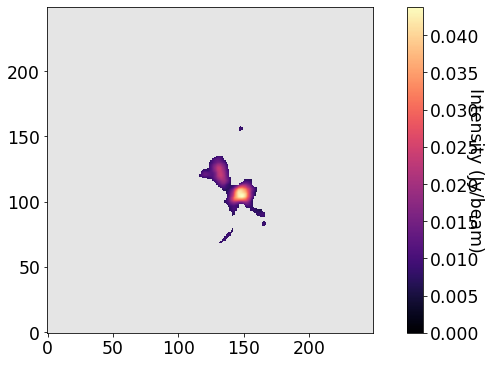

In [59]:
frame = 0
hdu_SO_vel = fits.open(file_par)[0]
cmap = cm.get_cmap('magma').copy()
cmap.set_bad('0.9')
#plt.imshow(projection=WCS(hdu_SO_vel.header), slices=('x', 'y', frame))
plt.imshow(hdu_SO_vel.data[frame, :, :], cmap=cmap, vmin=0)
plt.gca().invert_yaxis()
cbar = plt. colorbar()
cbar.set_label('Intensity (Jy/beam)', rotation=270)

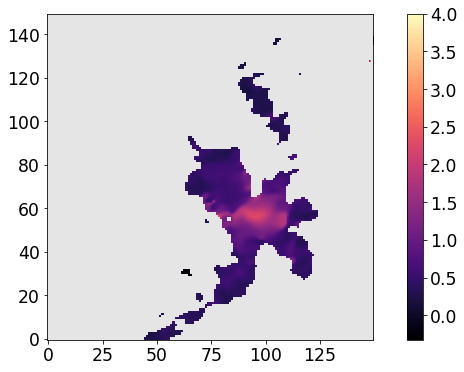

In [65]:
hdu_bright = load_cutout(file_dv)
cmap_bright = cm.get_cmap('magma').copy()
cmap_bright.set_bad('0.9')
#ax = plt.subplot(projection=WCS(hdu.header))
plt.imshow(hdu_bright.data, origin = "lower", cmap=cmap_bright)
cbar = plt. colorbar()
#cbar.set_label('Brightness (Jy/beam)', rotation=270)
plt.show()

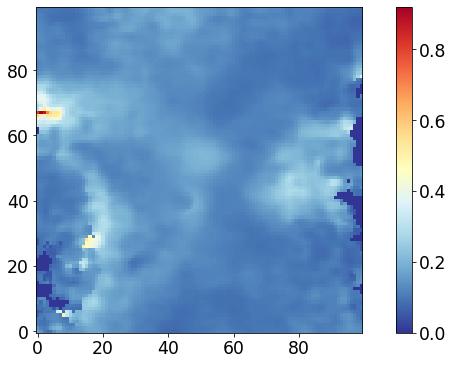

In [82]:
hdu = load_cutout('Documents/B335_N2Hp_dv.fits')
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.7')
#ax = plt.subplot(projection=WCS(hdu.header))
plt.imshow(hdu.data, origin = "lower", cmap=cmap)
cbar = plt. colorbar()
#cbar.set_label('Velocity (km/s)', rotation=270)
plt.show()

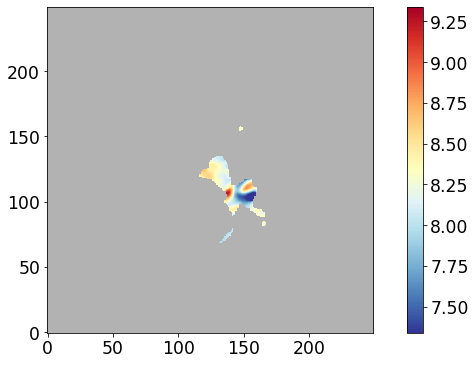

In [22]:
frame = 1
vlsr=8.34
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.7')
#ax = plt.subplot(projection=WCS(hdu_SO_vel.header), slices=('x', 'y', frame))
plt.imshow(hdu_SO_vel.data[frame, :, :], origin = 'lower', cmap=cmap, vmin=vlsr-1, vmax=vlsr+1)
cbar = plt.colorbar()
plt.show()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

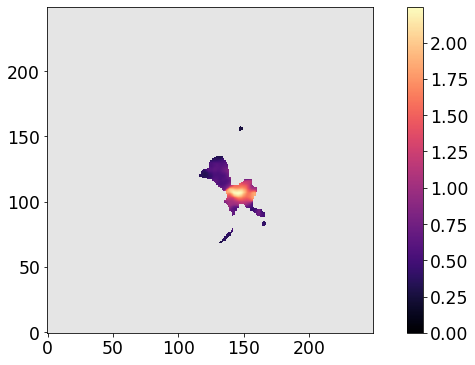

In [29]:
frame = 2
cmap = cm.get_cmap('magma').copy()
cmap.set_bad('0.9')
#ax = plt.subplot(projection=WCS(hdu_SO_vel.header), slices=('x', 'y', frame))
plt.imshow(hdu_SO_vel.data[frame, :, :], origin = 'lower', cmap=cmap, vmin = 0)
cbar = plt.colorbar()
plt.show()

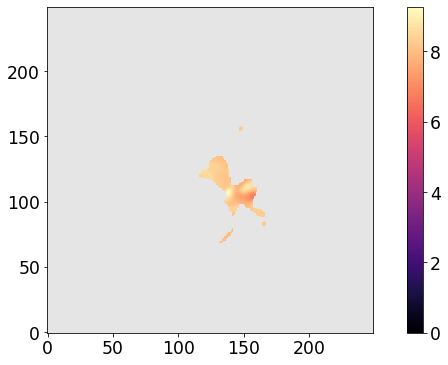

In [43]:
frame = 1
cmap = cm.get_cmap('magma').copy()
cmap.set_bad('0.9')
#ax = plt.subplot(projection=WCS(hdu_SO_vel.header), slices=('x', 'y', frame))
plt.imshow(hdu_SO_vel.data[frame, :, :], origin = 'lower', cmap=cmap, vmin = 0)
cbar = plt.colorbar()
plt.show()

In [26]:
hdu_SO_vel.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  250                                                  
NAXIS2  =                  250                                                  
NAXIS3  =                    6                                                  
BMAJ    =   3.438504045613E-05                                                  
BMIN    =   2.530604261600E-05                                                  
BPA     =  -5.963892815007E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'B335    '                                                            
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   1.836739800945E+

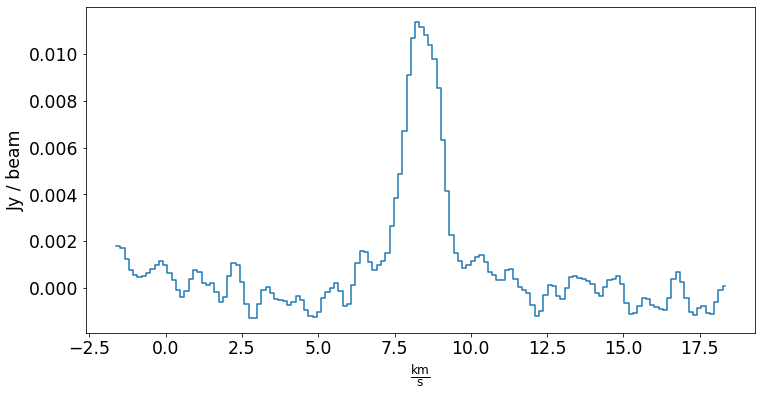

In [63]:
Sub_Cube_SO[:, 125, 125].quicklook()

In [15]:
cube

<Cube object over spectral range -1.6944 : 18.325 km / s and flux range = [nan, nan] Jy / beam with shape (144, 250, 250) at 0x7ff3d9fce7c>

In [16]:
Cube_SO_vel.allow_huge_operations=True

In [18]:
Tp = Cube_SO_vel.max(axis=0)

In [53]:
SO_TdV = Cube_SO_vel.moment(order=0, axis=0)

In [45]:
Cube_N2Hp = SpectralCube.read('Documents/B335/data/B335_N2H+_10_K_v1.fits')

Cube is a Stokes cube, returning spectral cube for I component


In [74]:
N2Hp_dv = Cube_N2Hp.moment(order=2, axis=0)

Note that the second moment returned will be a variance map. To get a linewidth map, use the SpectralCube.linewidth_fwhm() or SpectralCube.linewidth_sigma() methods instead.
invalid value encountered in true_divide
invalid value encountered in true_divide


In [76]:
fits.writeto('Documents/B335_N2Hp_dv_cubedirect.fits', N2Hp_dv.data, N2Hp_dv.header, overwrite=True)